In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
sns.set()

## Parameter Values and Initial Conditions

In [2]:
l = 0.31 #Production rate for non-infected cancer cells
A = 44.6e9  #Carrying capacity
k = 3500 #Production rate of new viruses
r = 8.9e-13 #Infection rate of non-infected cancer cells
m = 0.02  #Death rate of non-infected cancer cells
v = 2.3 #Death rate of viruses
u = 1 #Death rate of infected cancer rates

In [3]:
C0 = 1e9 #Non-infected cancer cells
I0 = 0 #Infected cancer cells
virus_dose = 1e11 #Viruses

x0 = [C0, I0, virus_dose] #Initial conditions

t_end = 5*365 #Simulation time: 5 years

## Functions

In [4]:
def Clinical_Model(t, x): #This function returns [C', I', V']
    C, I, V = x #Here x is a vector such that C=x[0], I=x[1], V=x[2]

    dC = l*C*(1-C/A) - r*V*C - m*C
    dI = r*V*C - u*I
    dV = k*I - v*V
    
    return [dC, dI, dV]

In [5]:
def Clinical_Study(ODE, total_vaccination_number, treatment_duration, longtime_duration, C0, I0, virus_dose):
    x0 = [C0, I0, virus_dose]
    xs = np.zeros((len(x0), longtime_duration+1))
    xs[:, 0] = x0

    for i in range(total_vaccination_number):
        xs[:, (1+i*treatment_duration):treatment_duration*(i+1)+1] = solve_ivp(ODE, (0, treatment_duration), x0, t_eval = np.linspace(1,treatment_duration,treatment_duration), method="Radau", rtol=1e-10, atol=1e-12).y
        x0 = xs[:, treatment_duration*(i+1)] + np.array([0, 0, virus_dose])
    
    xs[:, total_vaccination_number*treatment_duration+2:longtime_duration] = solve_ivp(ODE, (total_vaccination_number*treatment_duration+2, longtime_duration), xs[:, total_vaccination_number*treatment_duration], t_eval = np.linspace(total_vaccination_number*treatment_duration+2, longtime_duration, longtime_duration-total_vaccination_number*treatment_duration-2), method="Radau", rtol=1e-10, atol=1e-12).y
    
    return xs

In [6]:
def Constant_Treatment(ODE, total_vaccination_number, treatment_duration, longtime_duration, C0, I0, virus_dose):
    x0 = [C0, I0, virus_dose]
    xs = np.zeros((len(x0), longtime_duration+1))
    xs[:, 0] = x0

    for i in range(total_vaccination_number):
        xs[:, (1+i*treatment_duration):treatment_duration*(i+1)+1] = solve_ivp(ODE, (0, treatment_duration), x0, t_eval = np.linspace(1,treatment_duration,treatment_duration), method="Radau", rtol=1e-10, atol=1e-12).y
        x0 = xs[:, treatment_duration*(i+1)] + np.array([0, 0, virus_dose])
    
    return xs

In [7]:
def Non_Constant_Treatment(ODE, treatment_duration, longtime_duration, C0, I0, virus_dose):
    x0 = [C0, I0, virus_dose]
    xs = np.zeros((len(x0), np.sum(longtime_duration)+1))
    xs[:, 0] = x0
    steps = np.zeros(longtime_duration.shape[0])

    for i in range(steps.shape[0]):
        steps[i] = int(longtime_duration[i]/treatment_duration[i])

        for j in range(int(steps[i])):
            if i == 0:
                xs[:, (1+j*treatment_duration[i]):treatment_duration[i]*(j+1)+1] = solve_ivp(ODE, (0, treatment_duration[i]), x0, t_eval = np.linspace(1,treatment_duration[i],treatment_duration[i]), method="Radau", rtol=1e-10, atol=1e-12).y
                x0 = xs[:, treatment_duration[i]*(j+1)] + np.array([0, 0, virus_dose])
            else:
                xs[:, (1+np.sum(longtime_duration[:i])+j*treatment_duration[i]):(np.sum(longtime_duration[:i])+treatment_duration[i]*(j+1)+1)] = solve_ivp(ODE, (0, treatment_duration[i]), x0, t_eval = np.linspace(1,treatment_duration[i],treatment_duration[i]), method="Radau", rtol=1e-10, atol=1e-12).y
                x0 = xs[:, np.sum(longtime_duration[:i])+treatment_duration[i]*j+1] + np.array([0, 0, virus_dose])

    return xs

## Single Vaccination on Day 0

In [8]:
single_vaccination = solve_ivp(Clinical_Model, t_span = (0, t_end), y0 = x0, method="Radau", rtol=1e-10, atol=1e-12, t_eval=np.linspace(0, t_end, t_end)).y

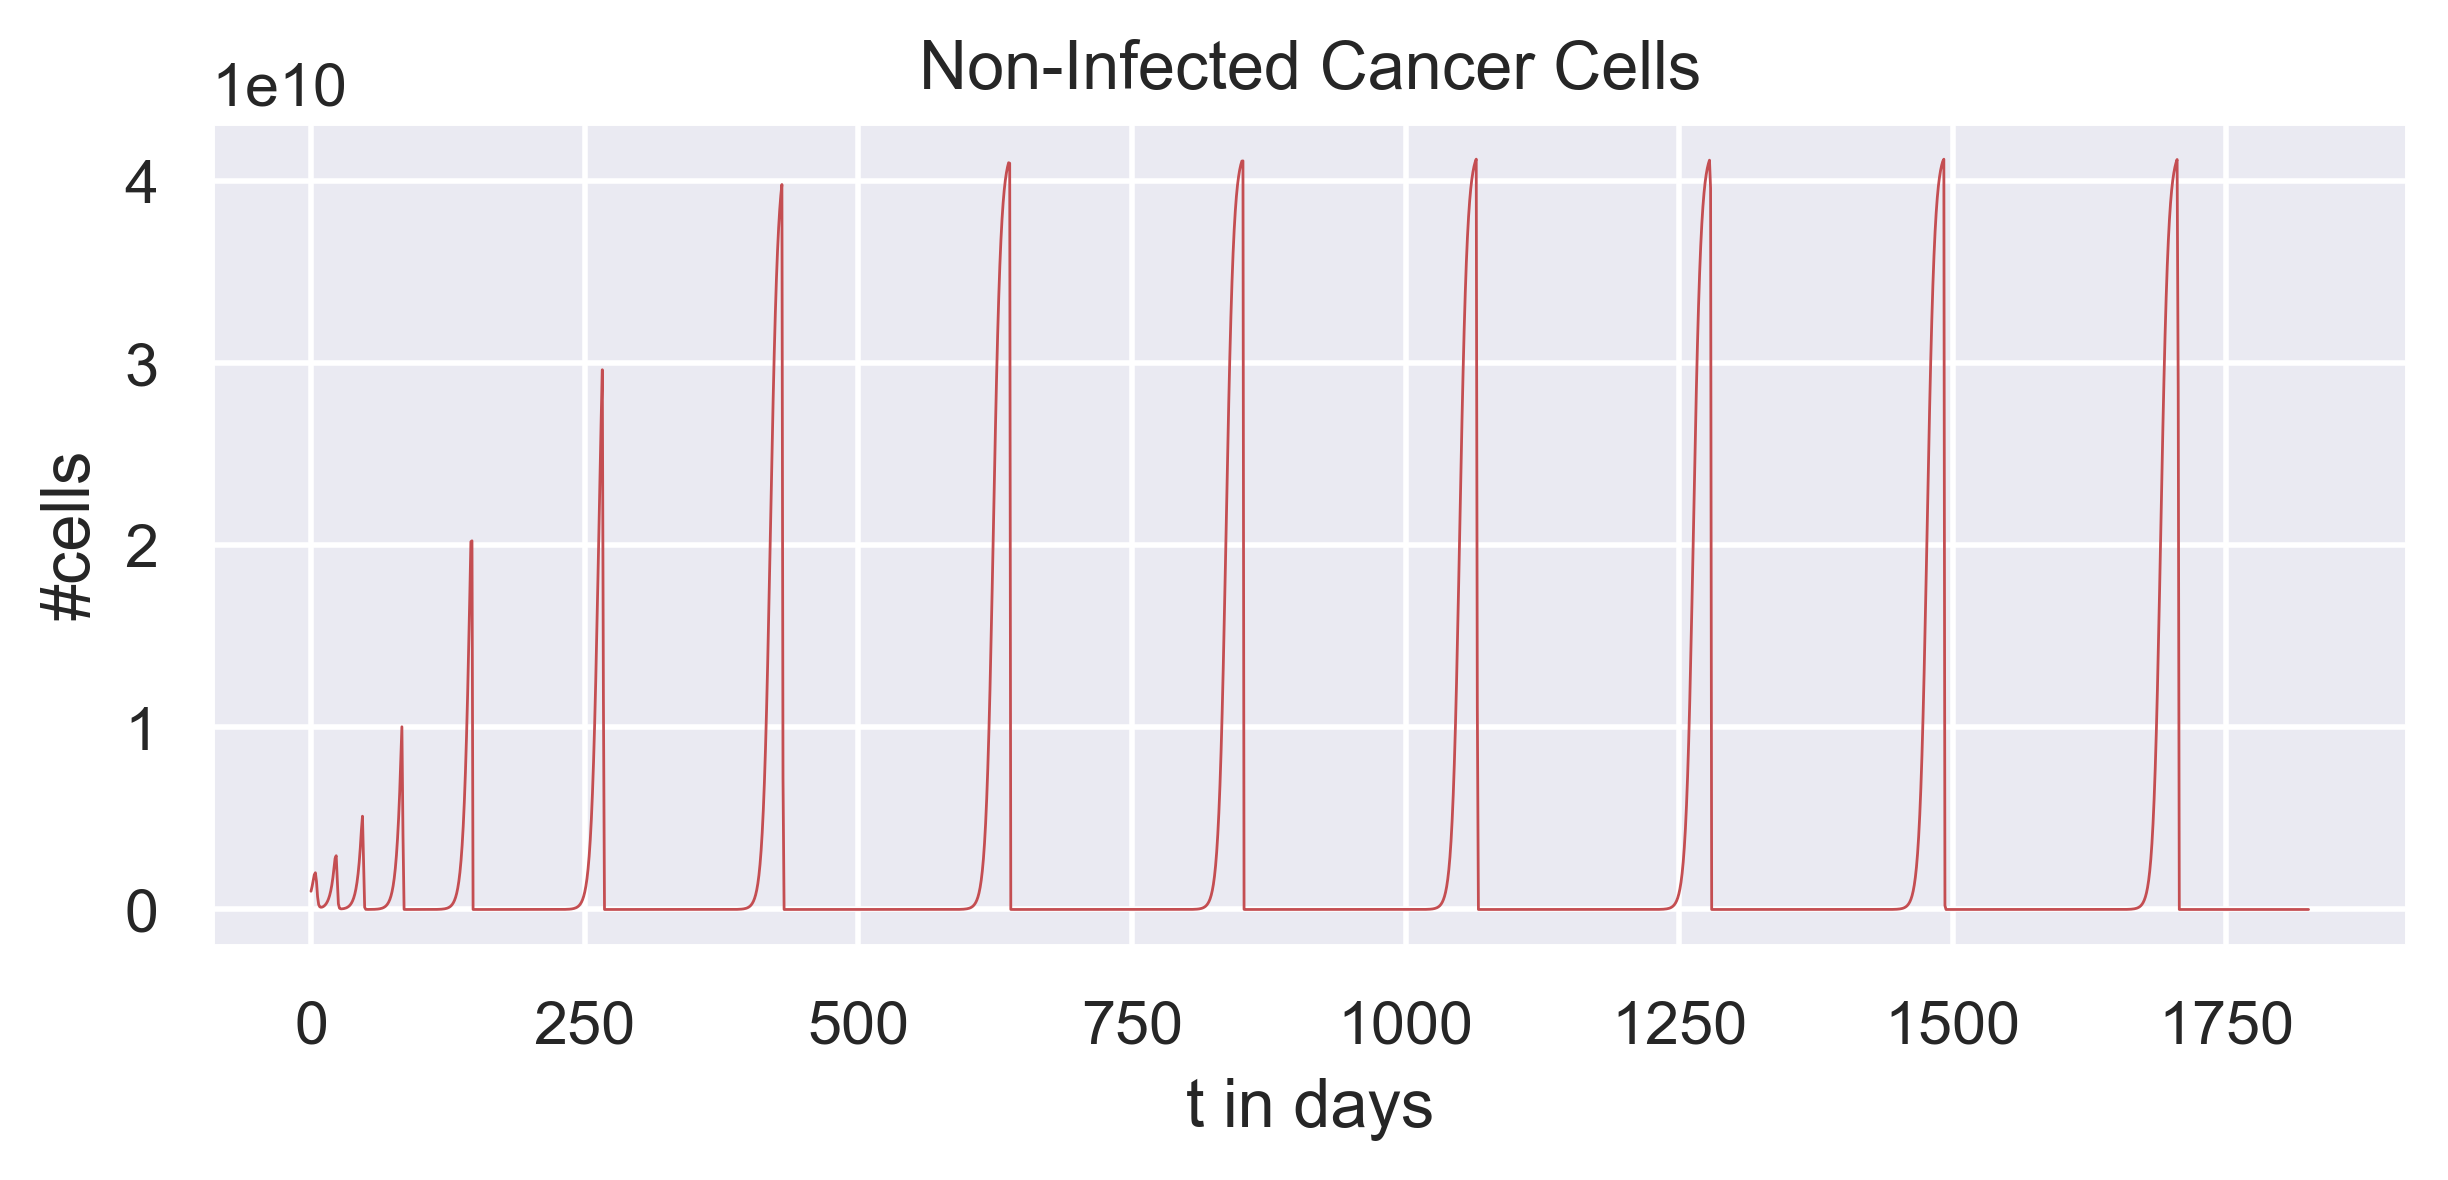

In [44]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end), single_vaccination[0], 'r-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Non-Infected Cancer Cells")

plt.show()

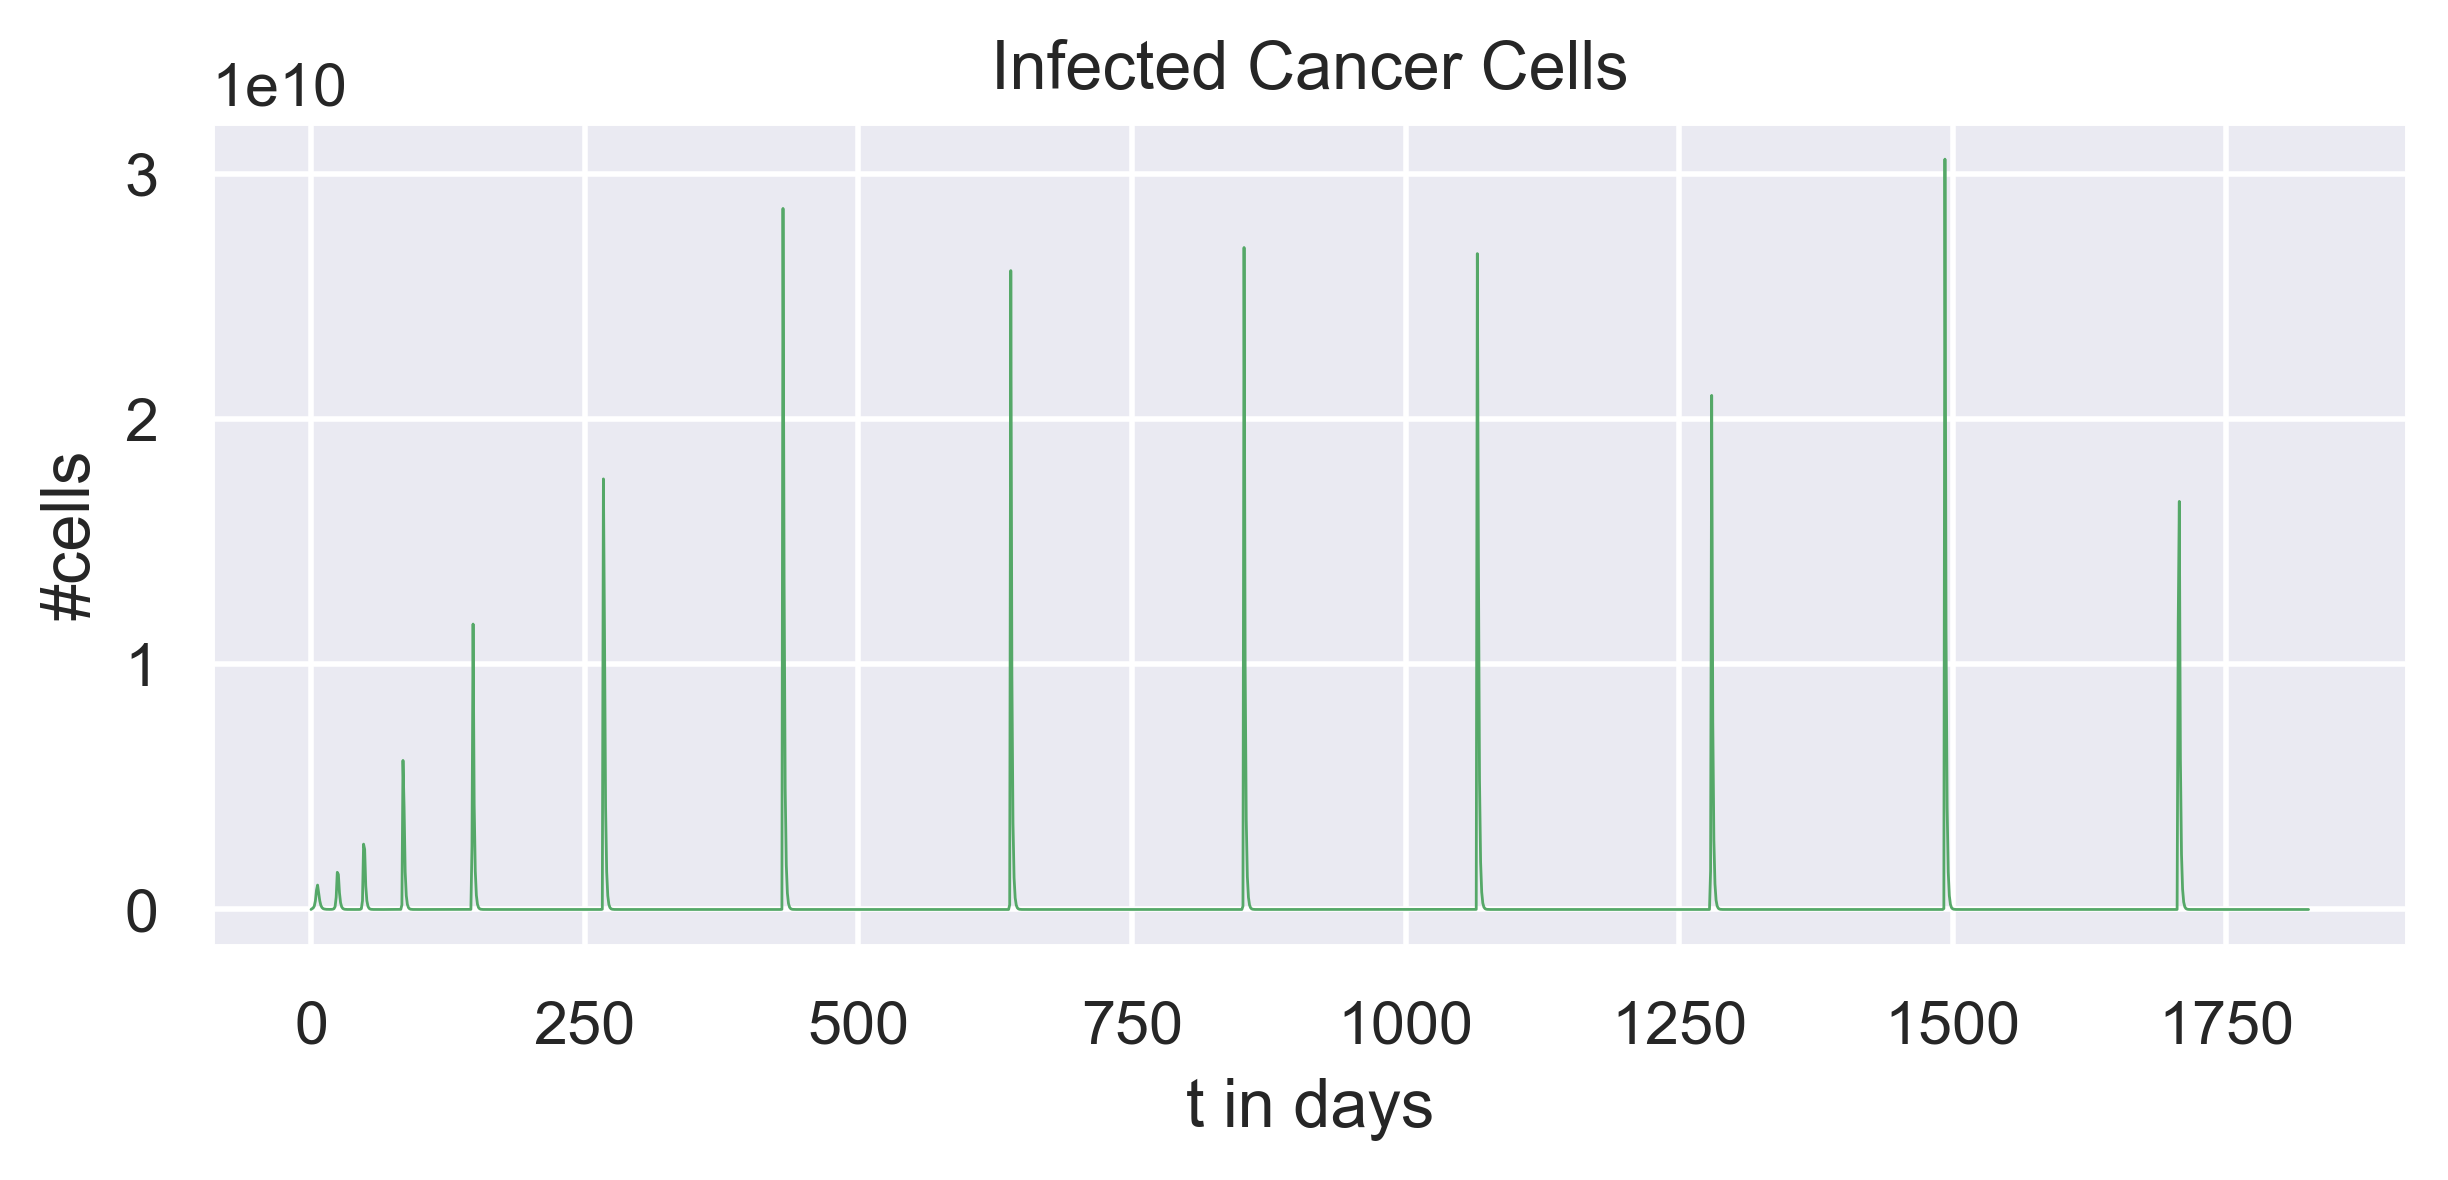

In [45]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end), single_vaccination[1], 'g-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Infected Cancer Cells")

plt.show()

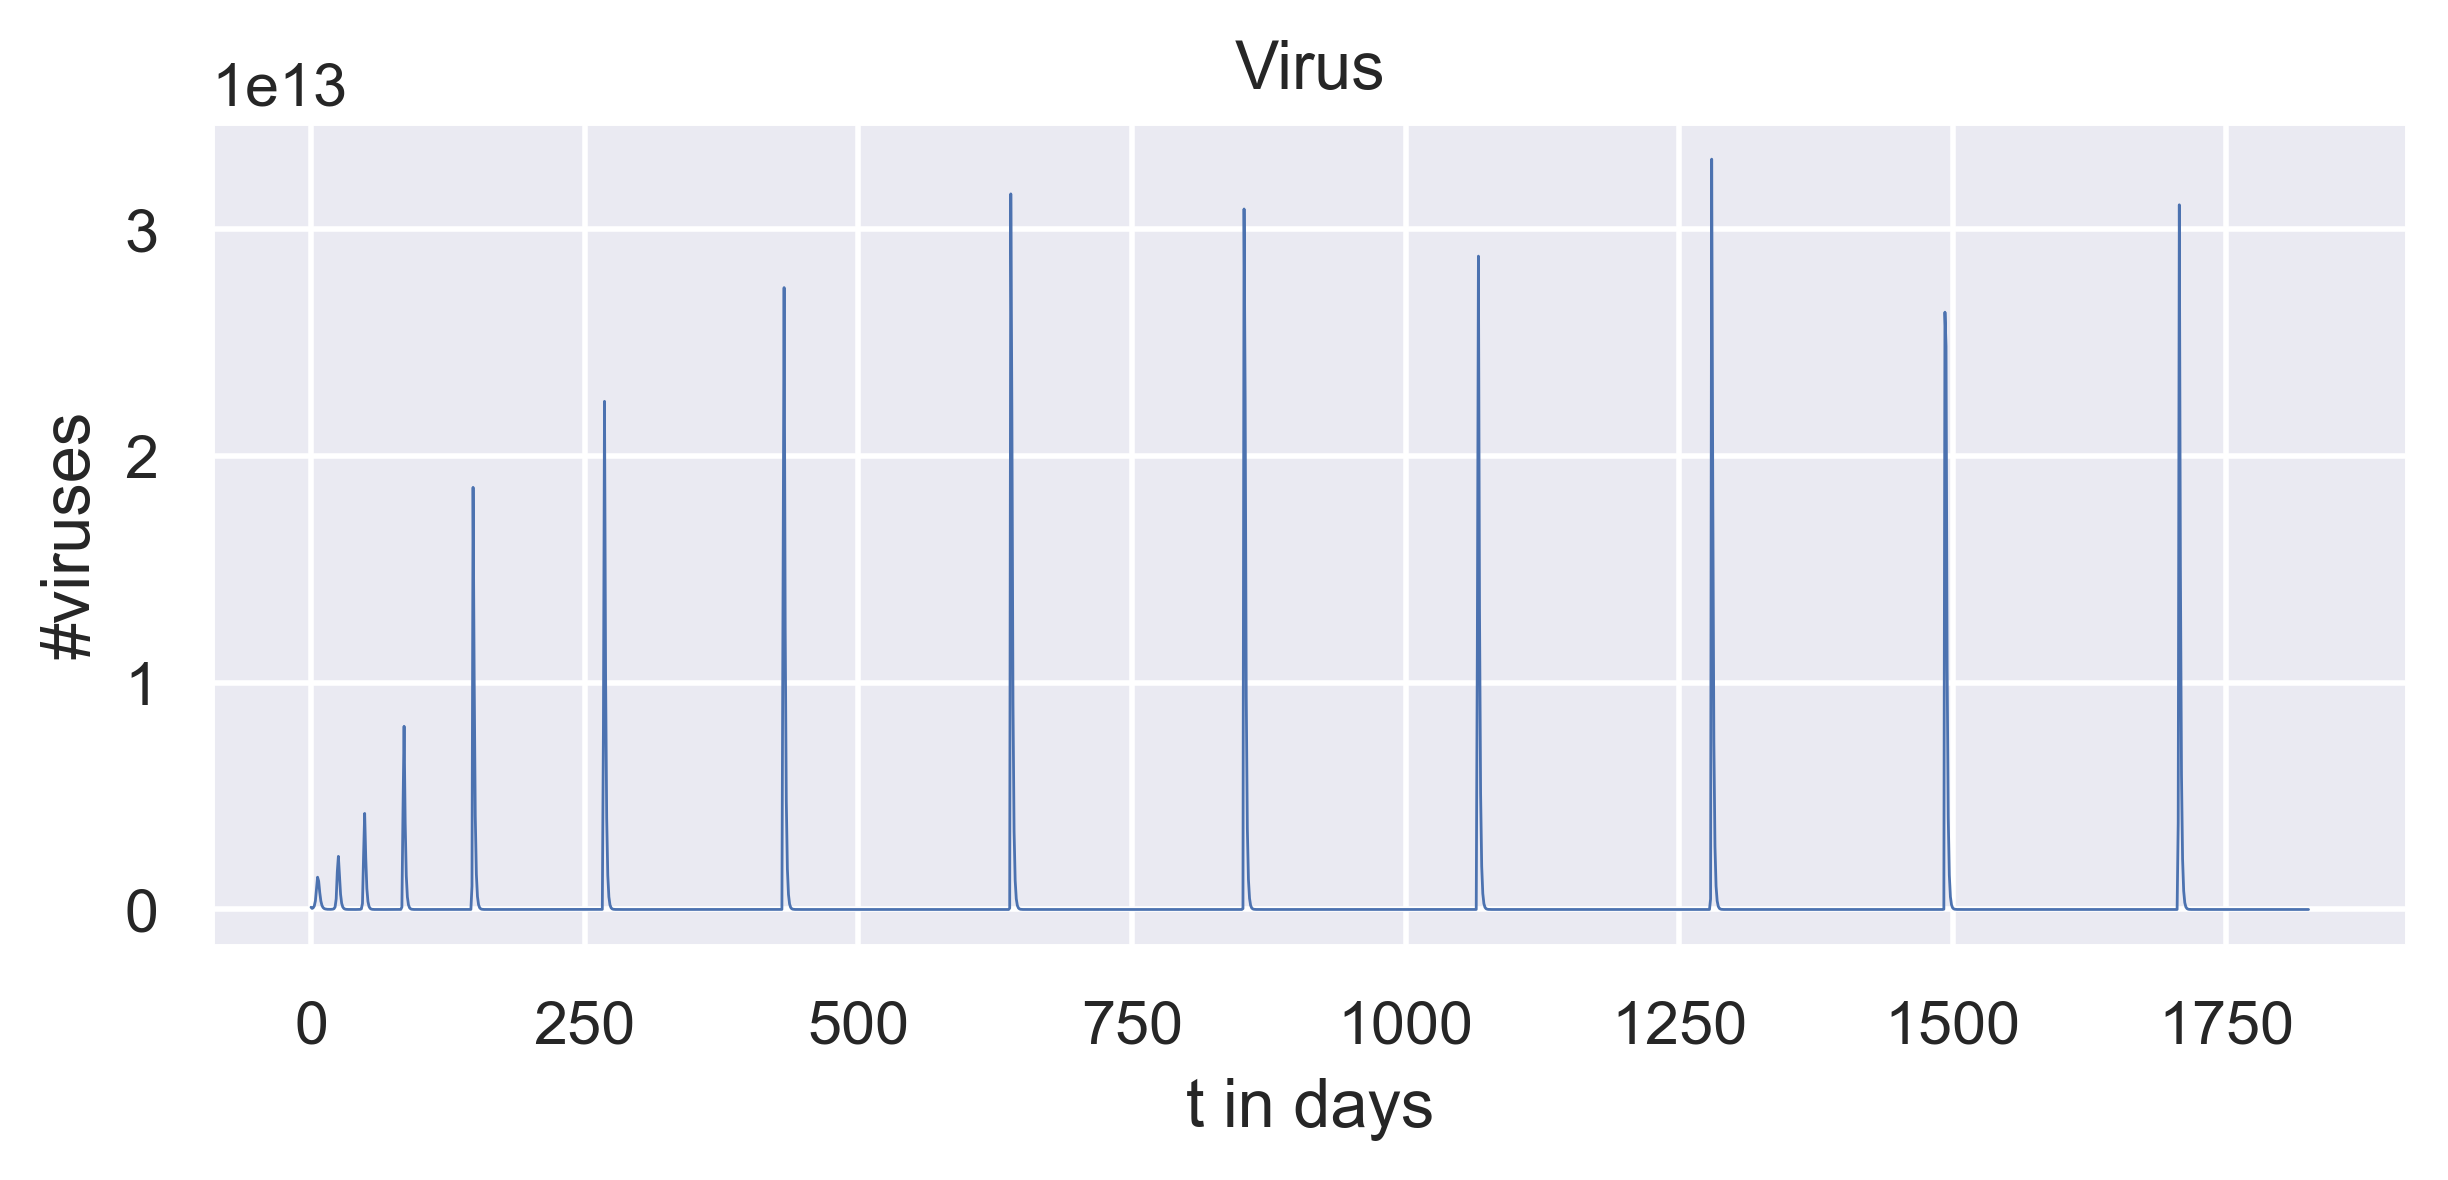

In [46]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end), single_vaccination[2], 'b-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#viruses")
plt.title("Virus")

plt.show()

## Two Vaccinations with a Time Lag of 14 Days

In [12]:
two_vaccinations_number = 2
two_vaccinations_treatment = 14

In [13]:
two_vaccinations = Clinical_Study(Clinical_Model, two_vaccinations_number, two_vaccinations_treatment, t_end, C0, I0, virus_dose)

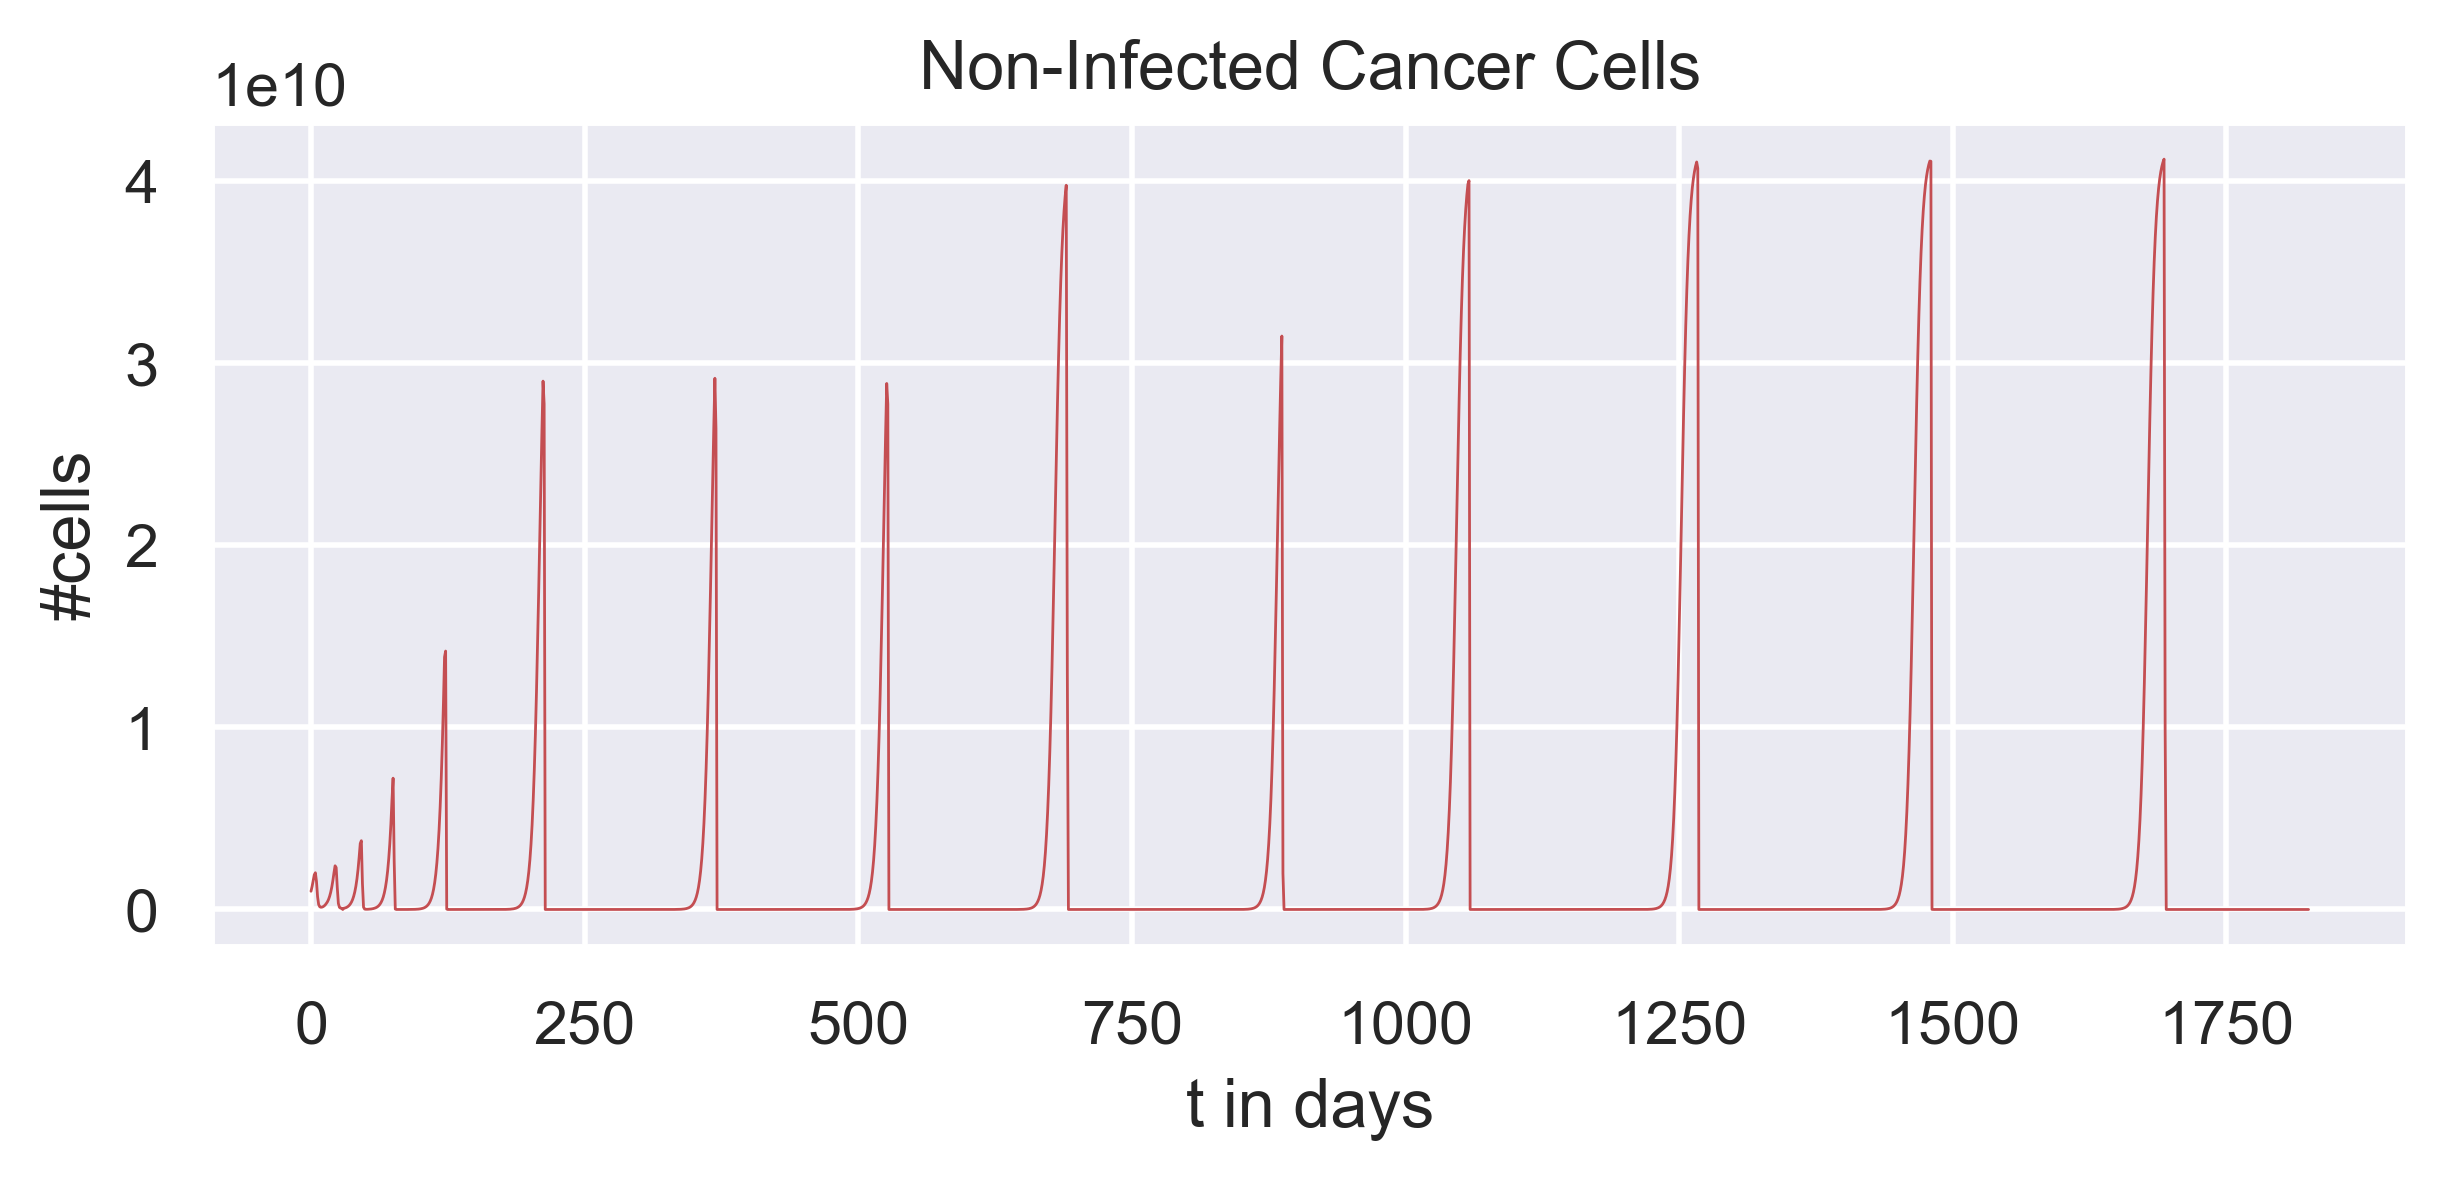

In [47]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), two_vaccinations[0], 'r-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Non-Infected Cancer Cells")

plt.show()

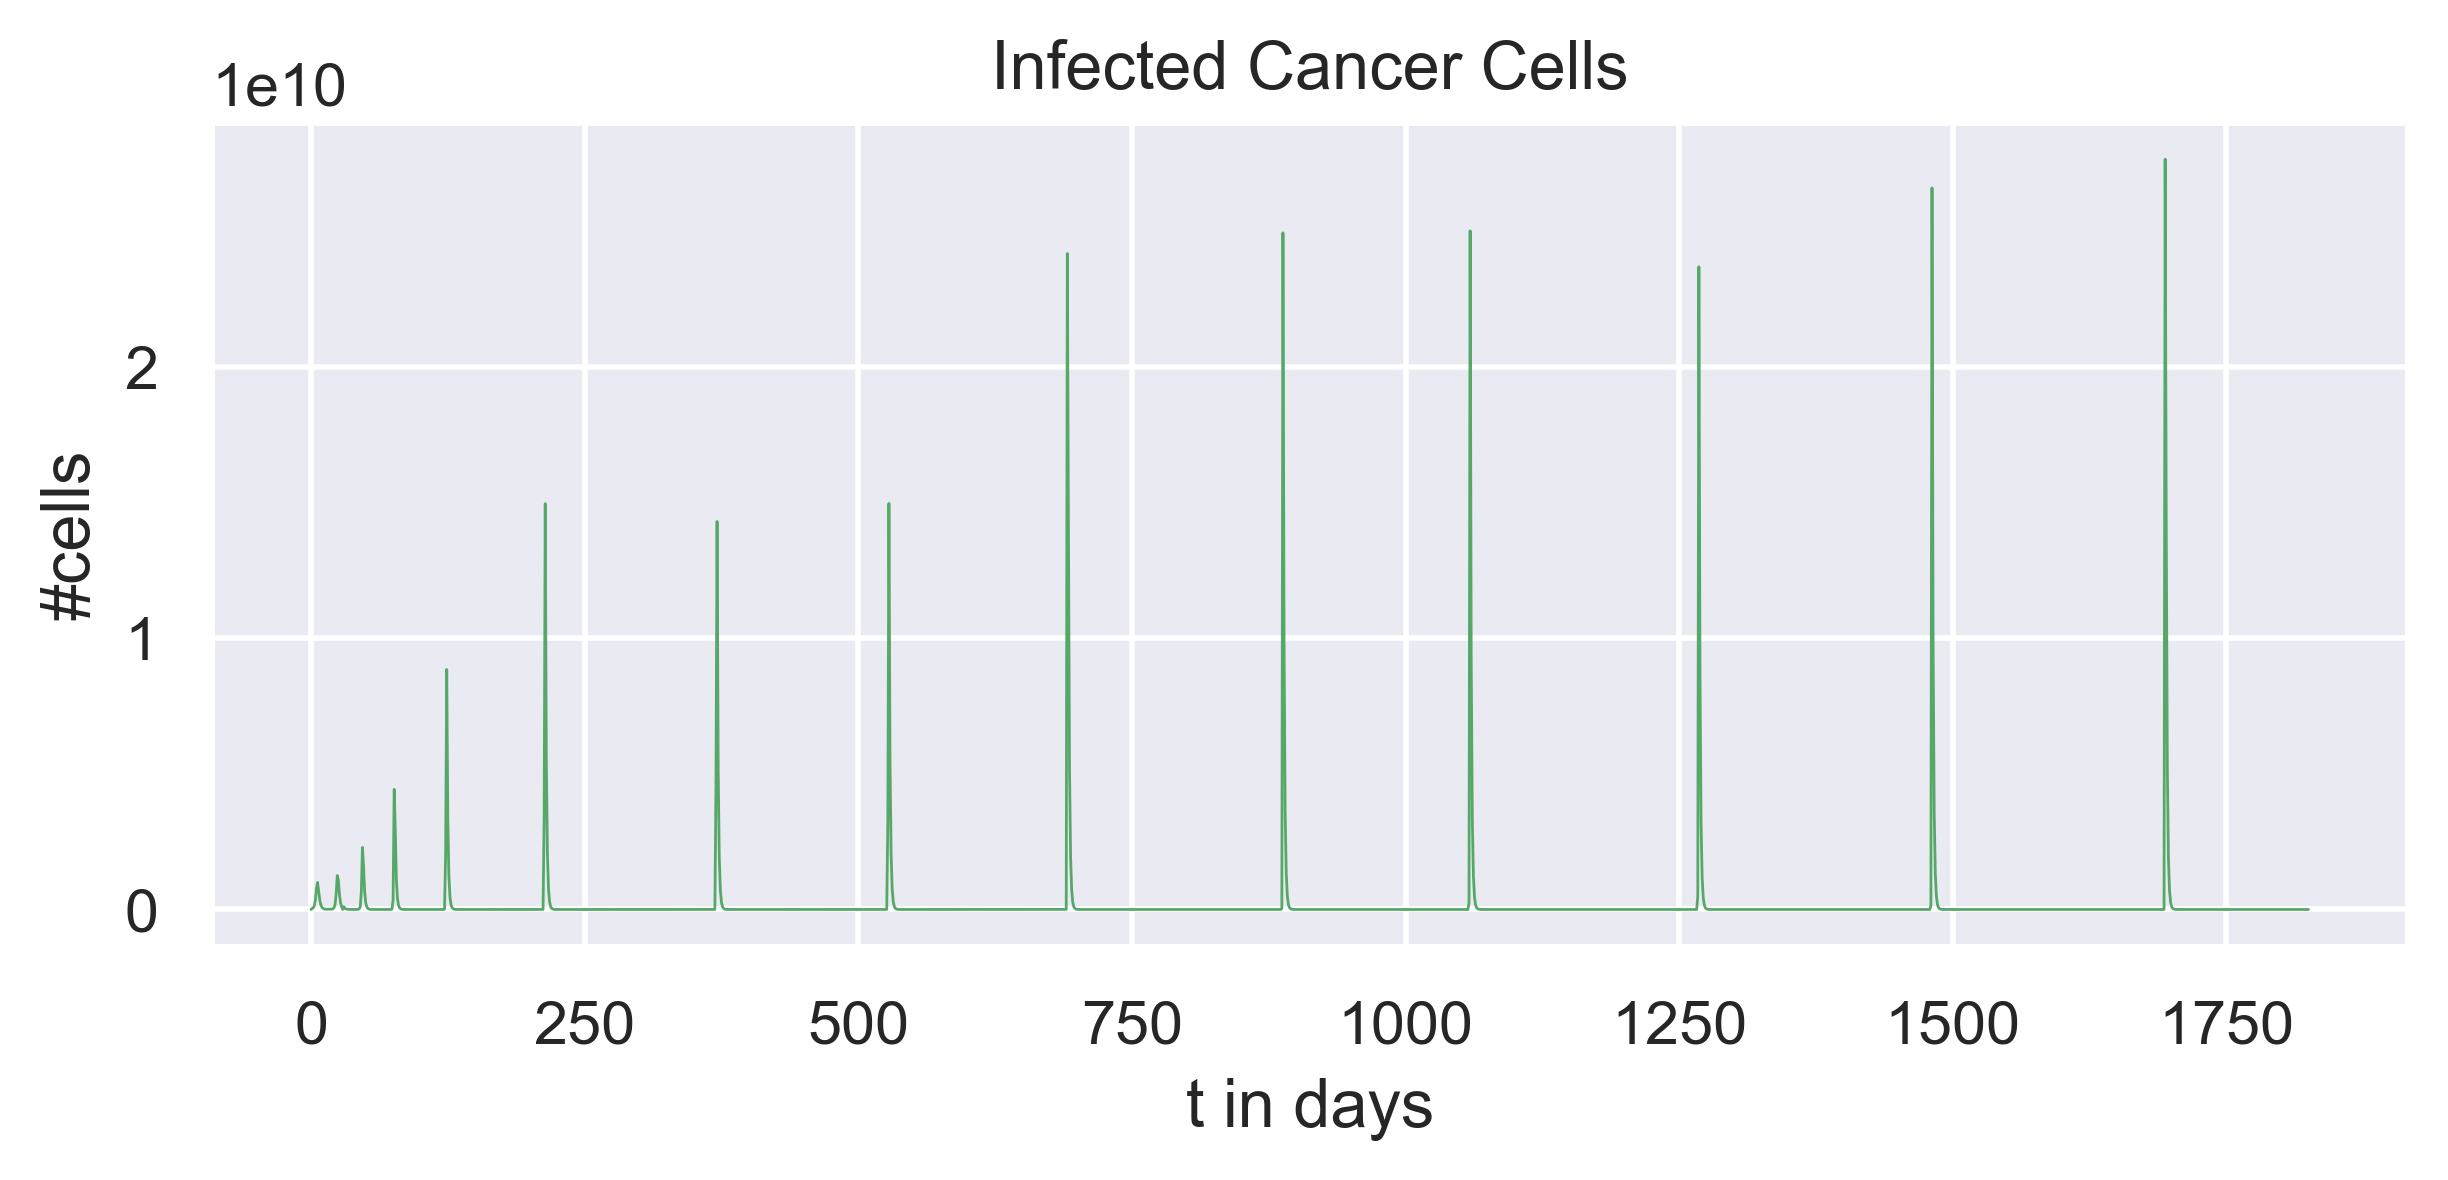

In [48]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), two_vaccinations[1], 'g-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Infected Cancer Cells")

plt.show()

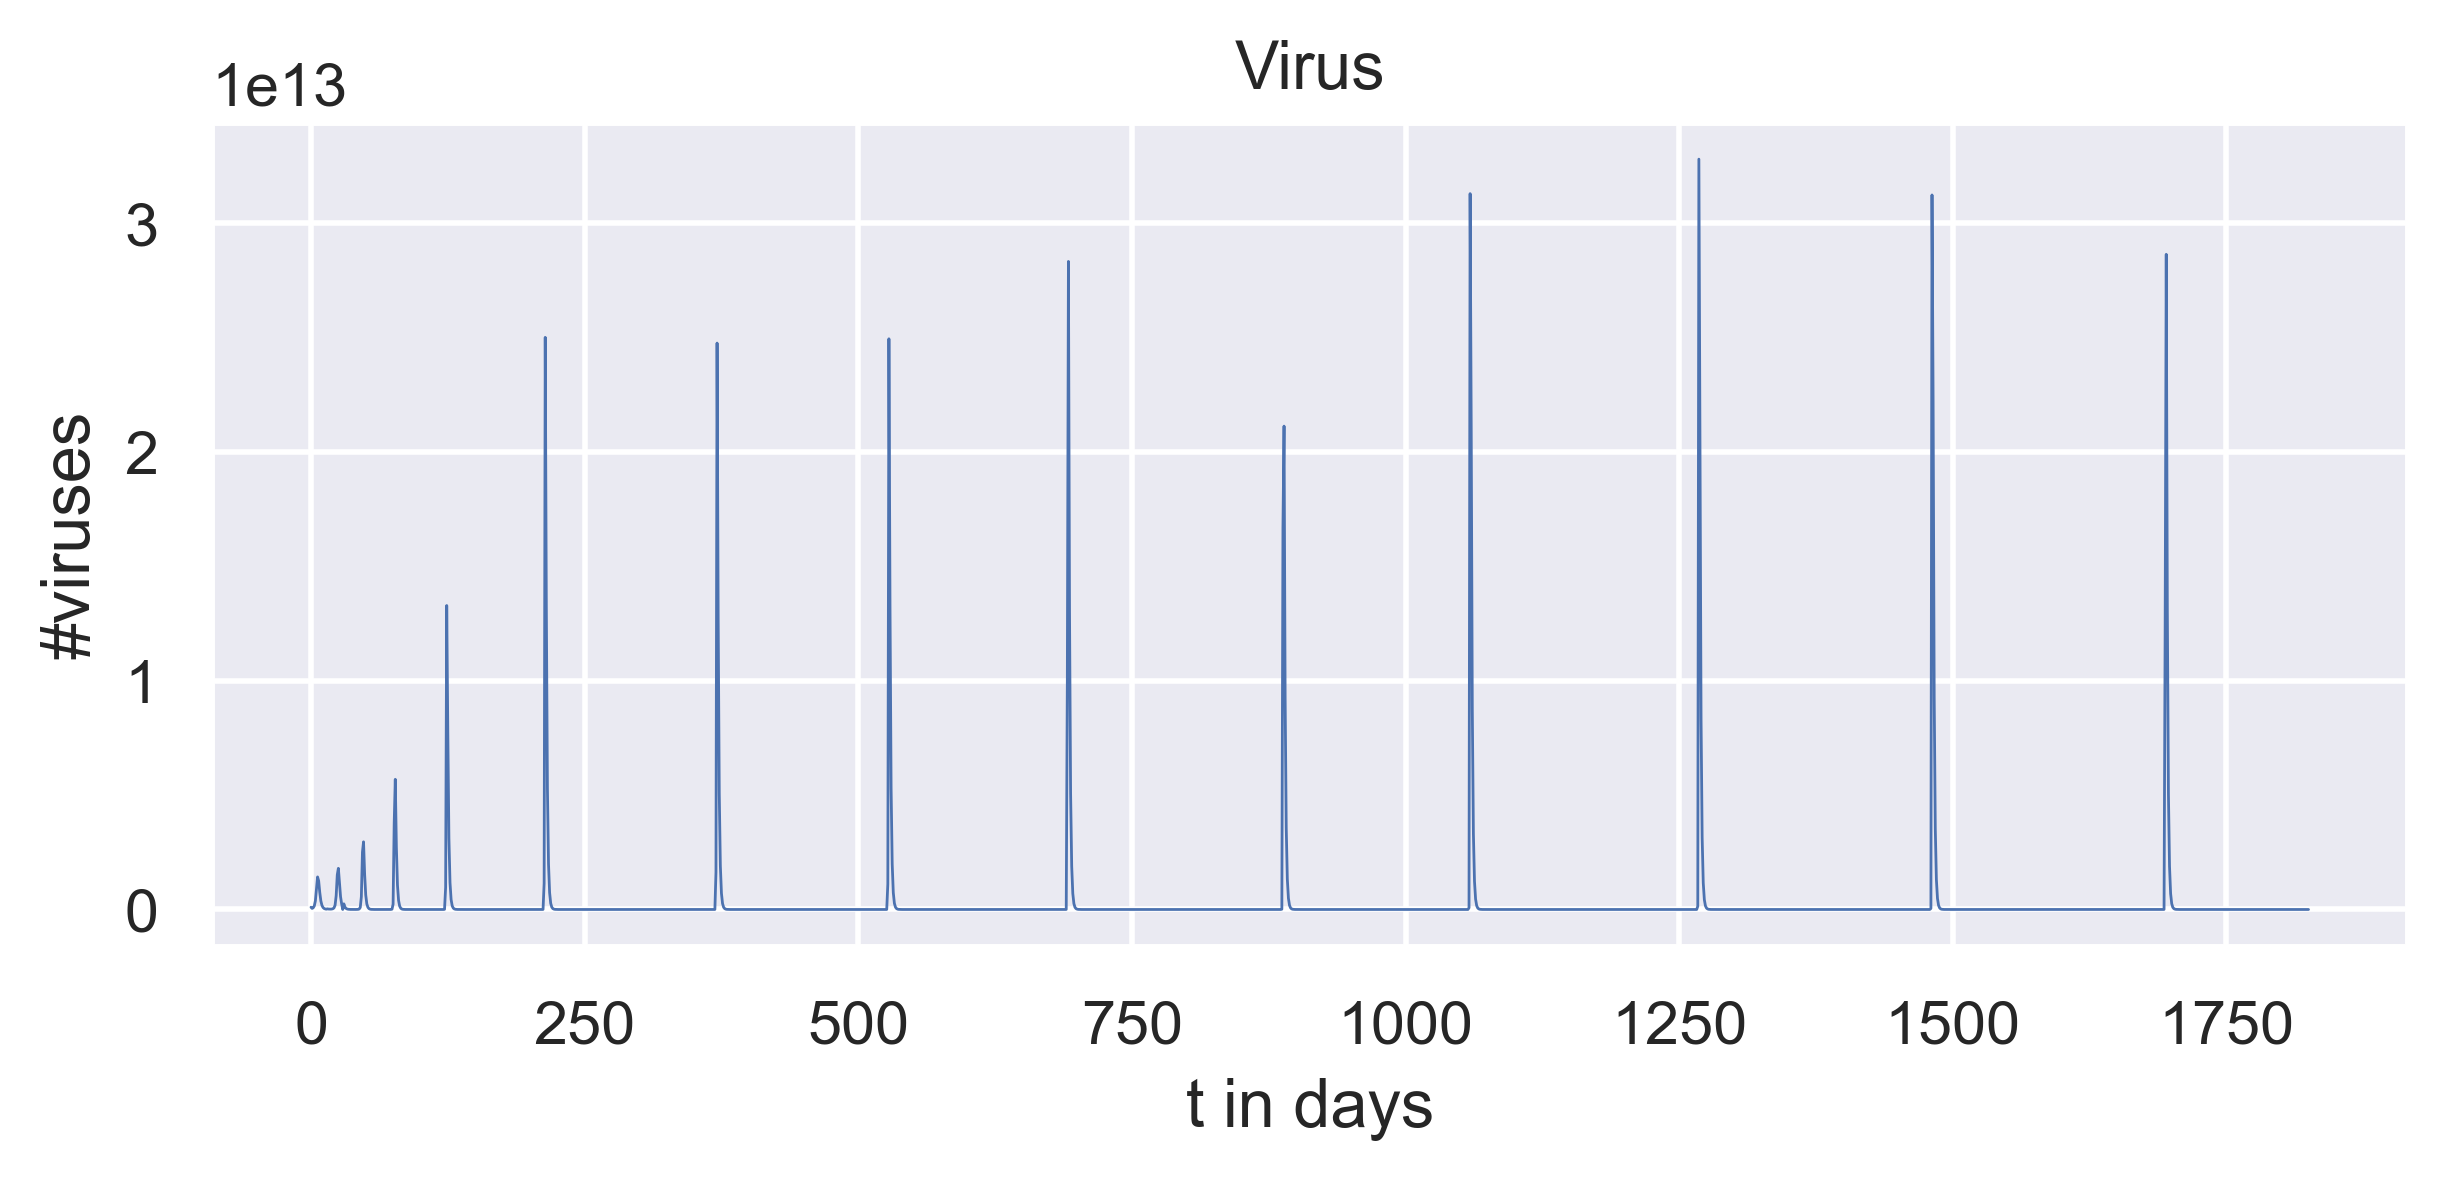

In [49]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), two_vaccinations[2], 'b-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#viruses")
plt.title("Virus")

plt.show()

## 12 Vaccinations every 60 Days (for Two Years)

In [17]:
twelve_vaccinations_number = 12
twelve_vaccinations_treatment = 60

In [18]:
twelve_vaccinations = Clinical_Study(Clinical_Model, twelve_vaccinations_number, twelve_vaccinations_number, t_end, C0, I0, virus_dose)

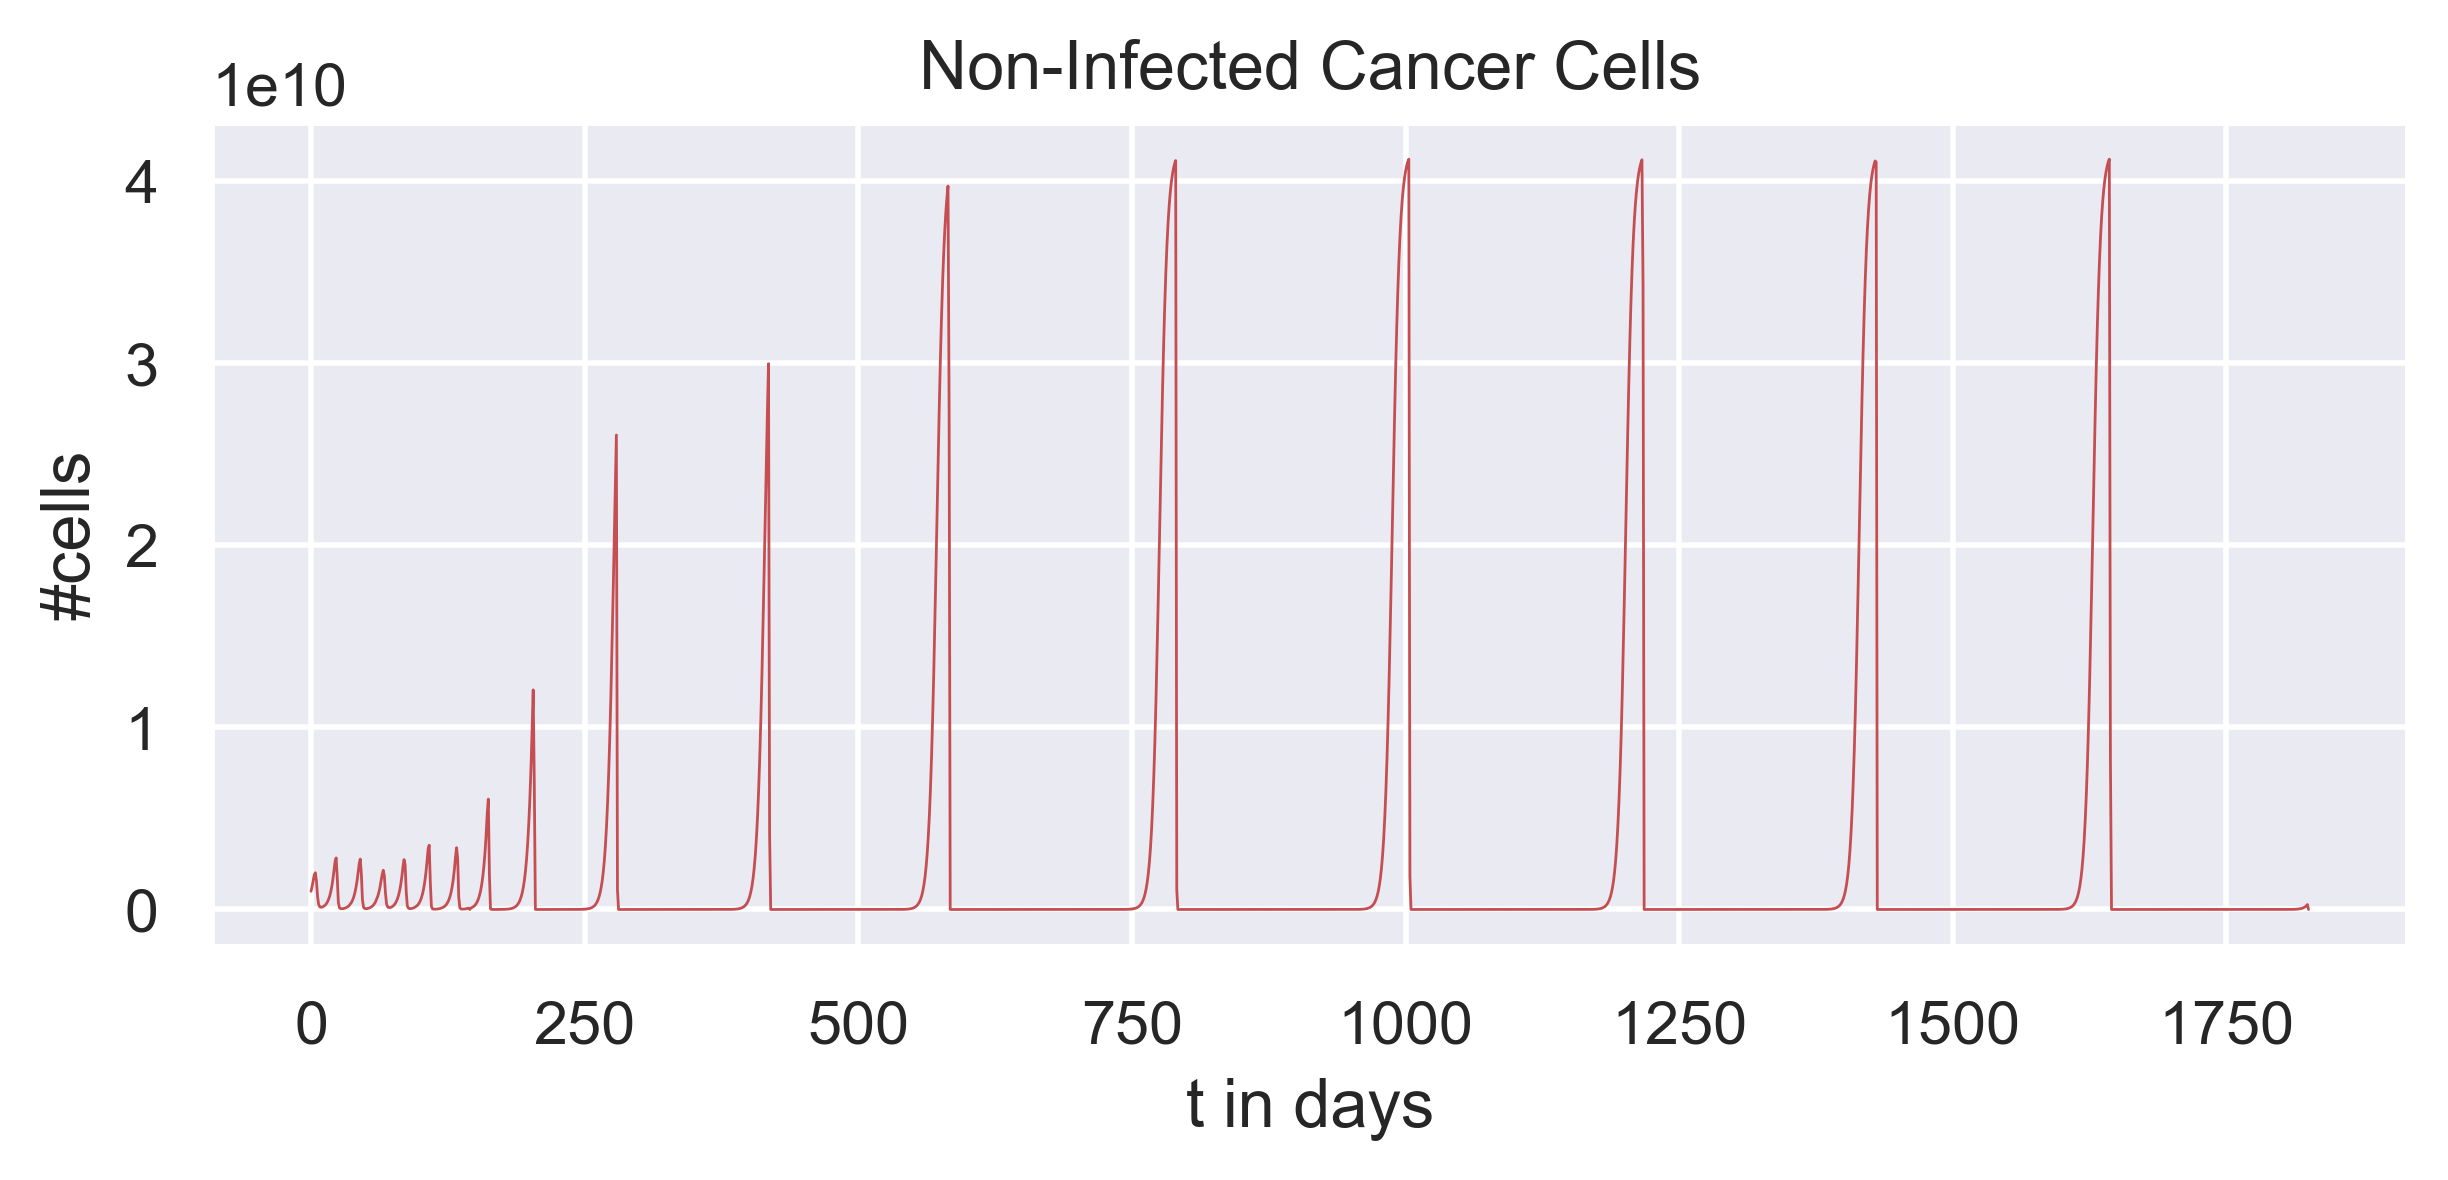

In [51]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), twelve_vaccinations[0], 'r-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Non-Infected Cancer Cells")

plt.show()

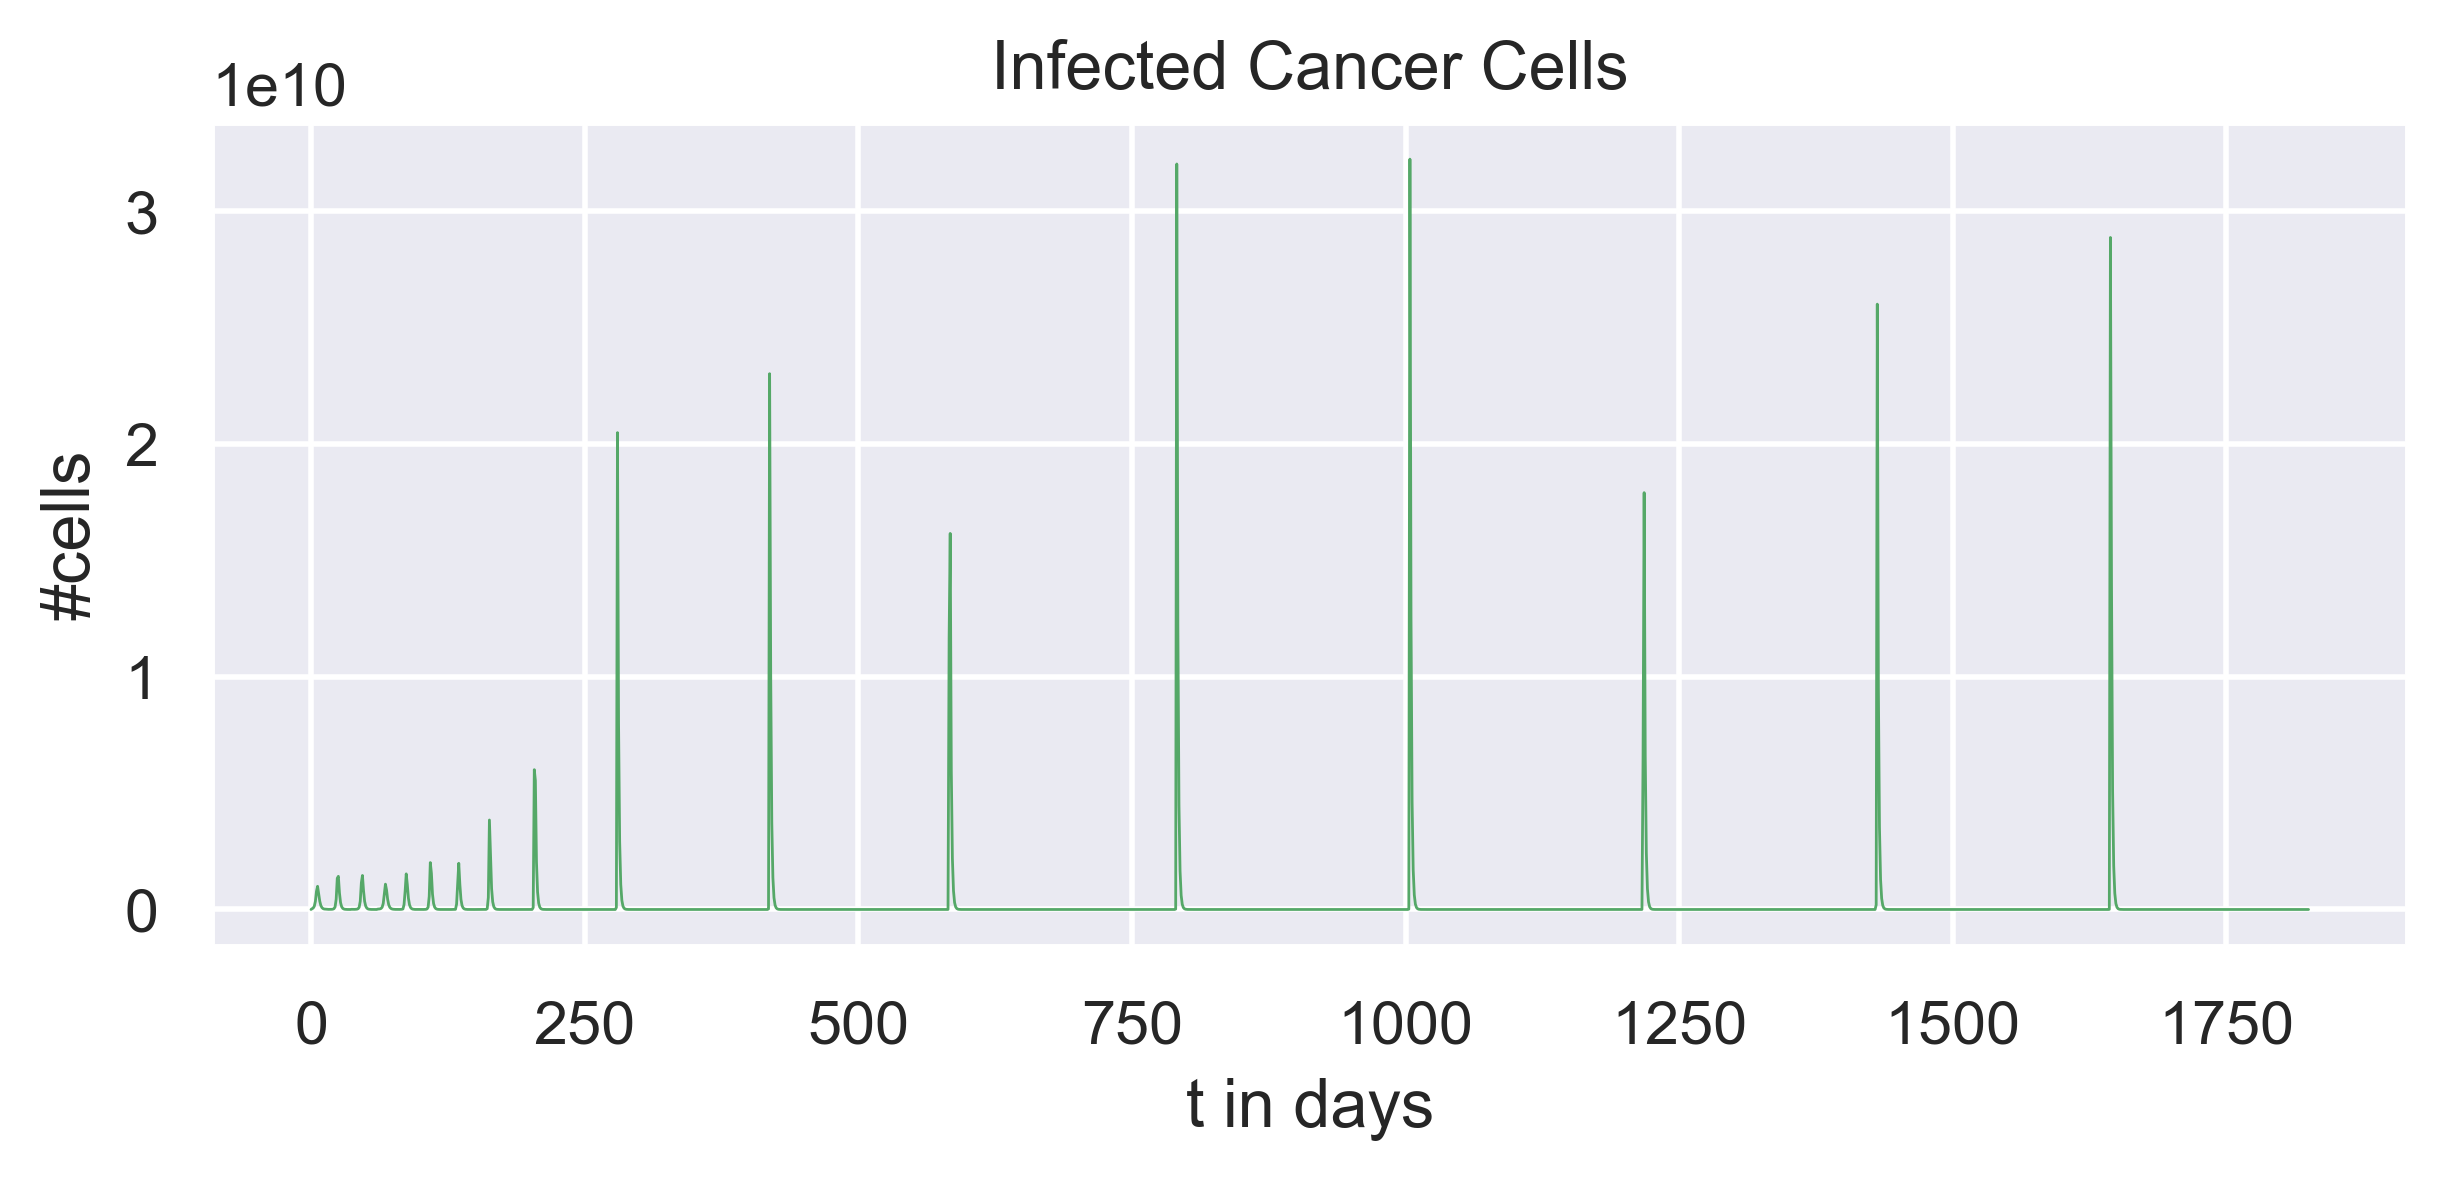

In [52]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), twelve_vaccinations[1], 'g-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Infected Cancer Cells")
plt.show()

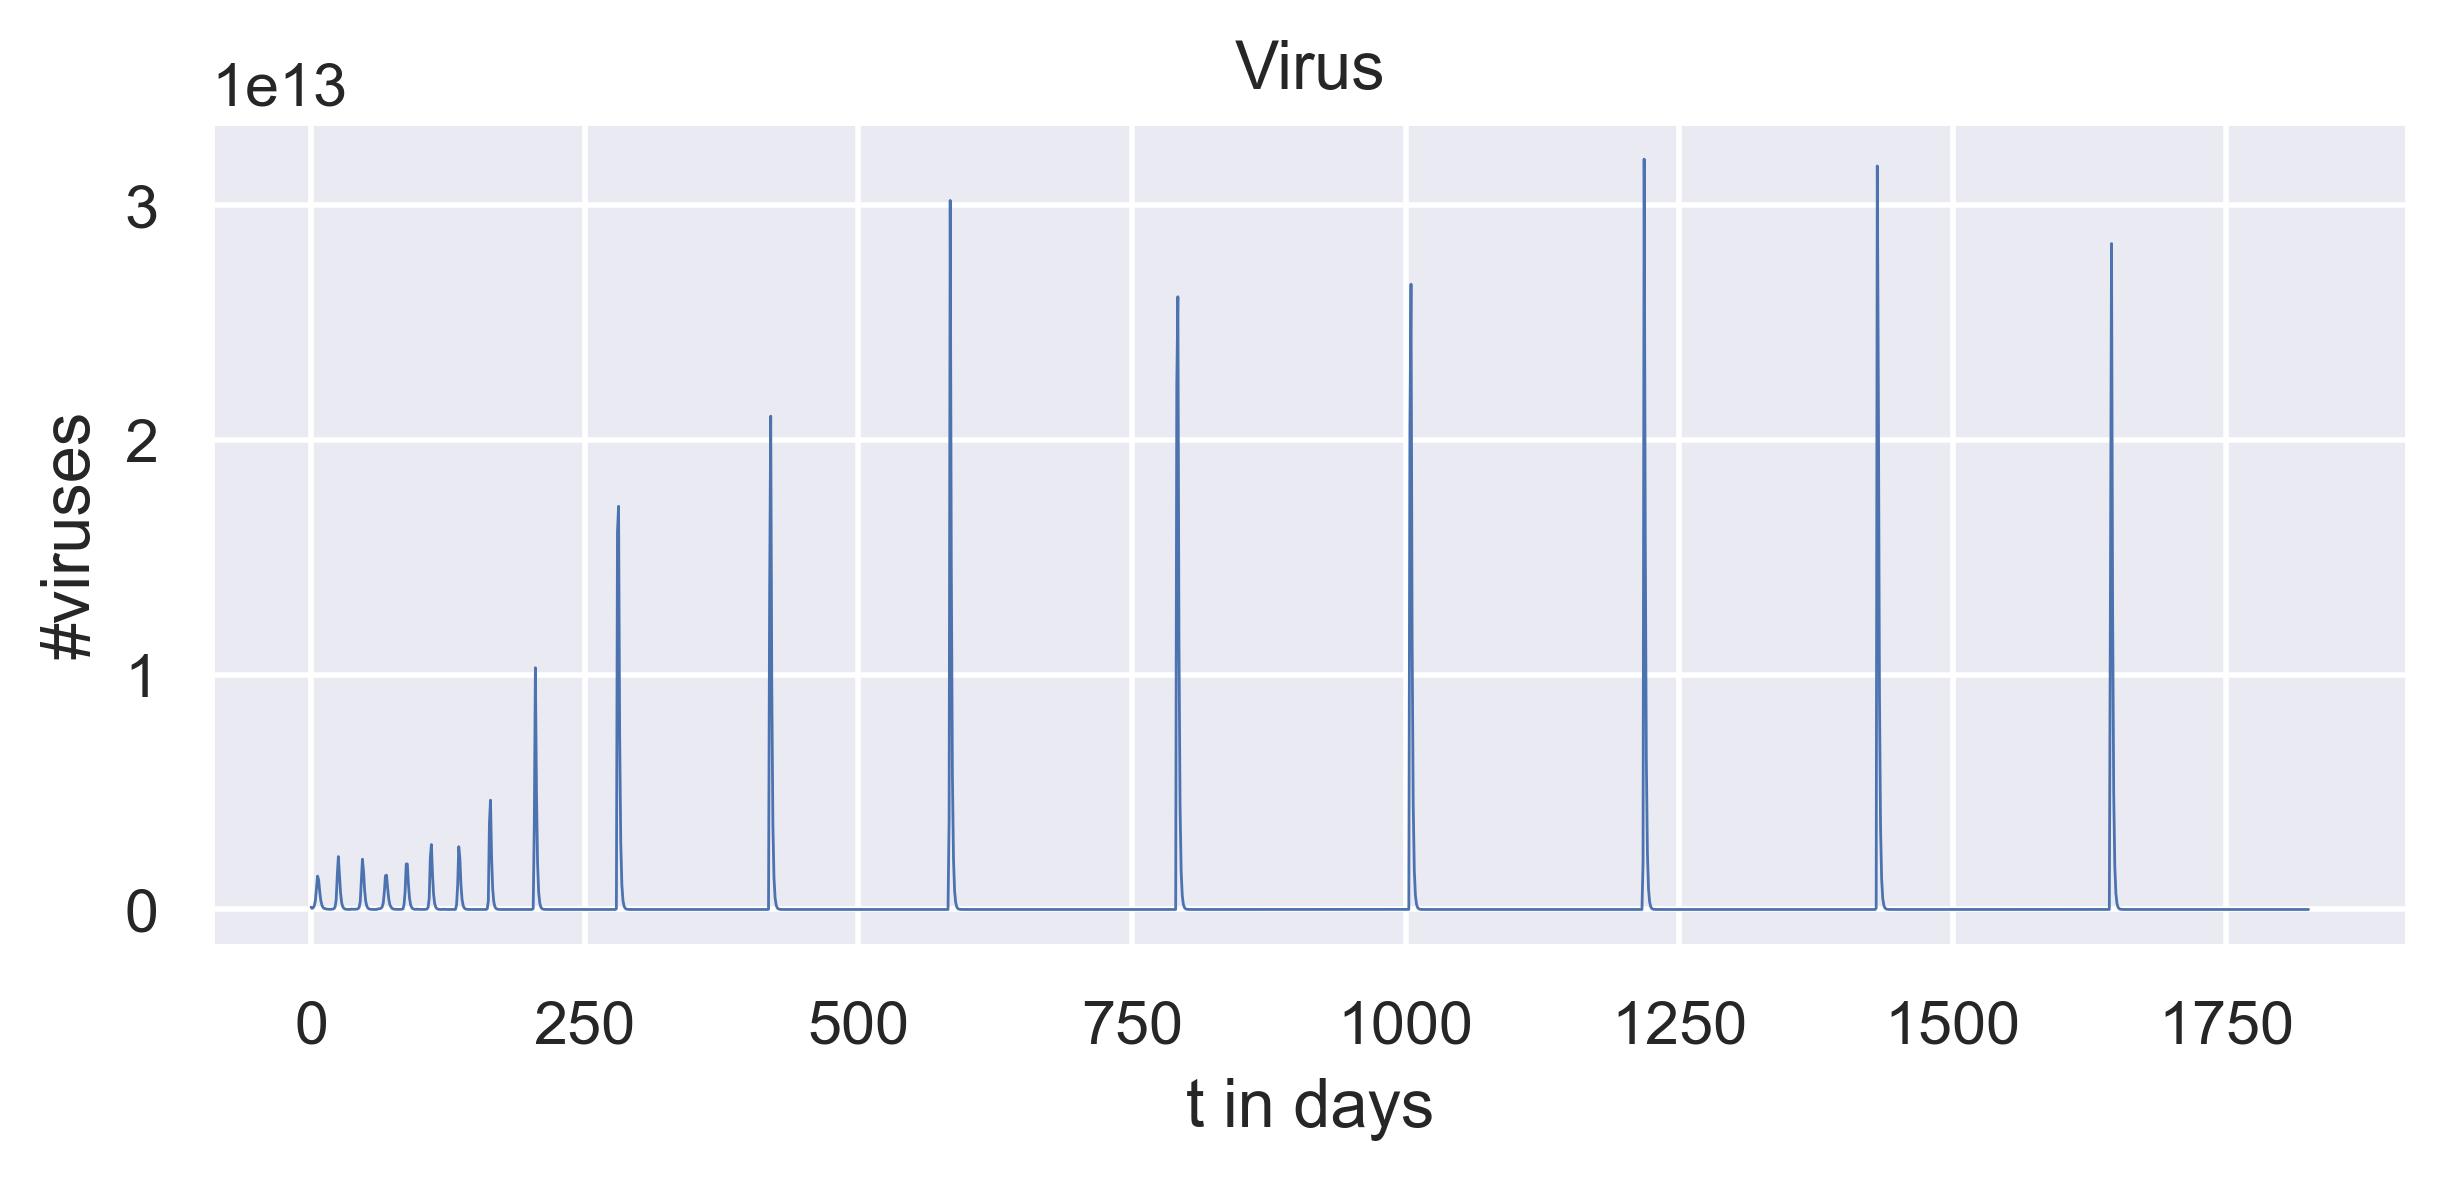

In [53]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), twelve_vaccinations[2], 'b-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#viruses")
plt.title("Virus")

plt.show()

## 30 Vaccinations every 60 Days

In [22]:
thirty_vaccinations_number = 30
thirty_vaccinations_treatment = 60

In [23]:
thirty_vaccinations = Constant_Treatment(Clinical_Model, thirty_vaccinations_number, thirty_vaccinations_treatment, t_end, C0, I0, virus_dose)

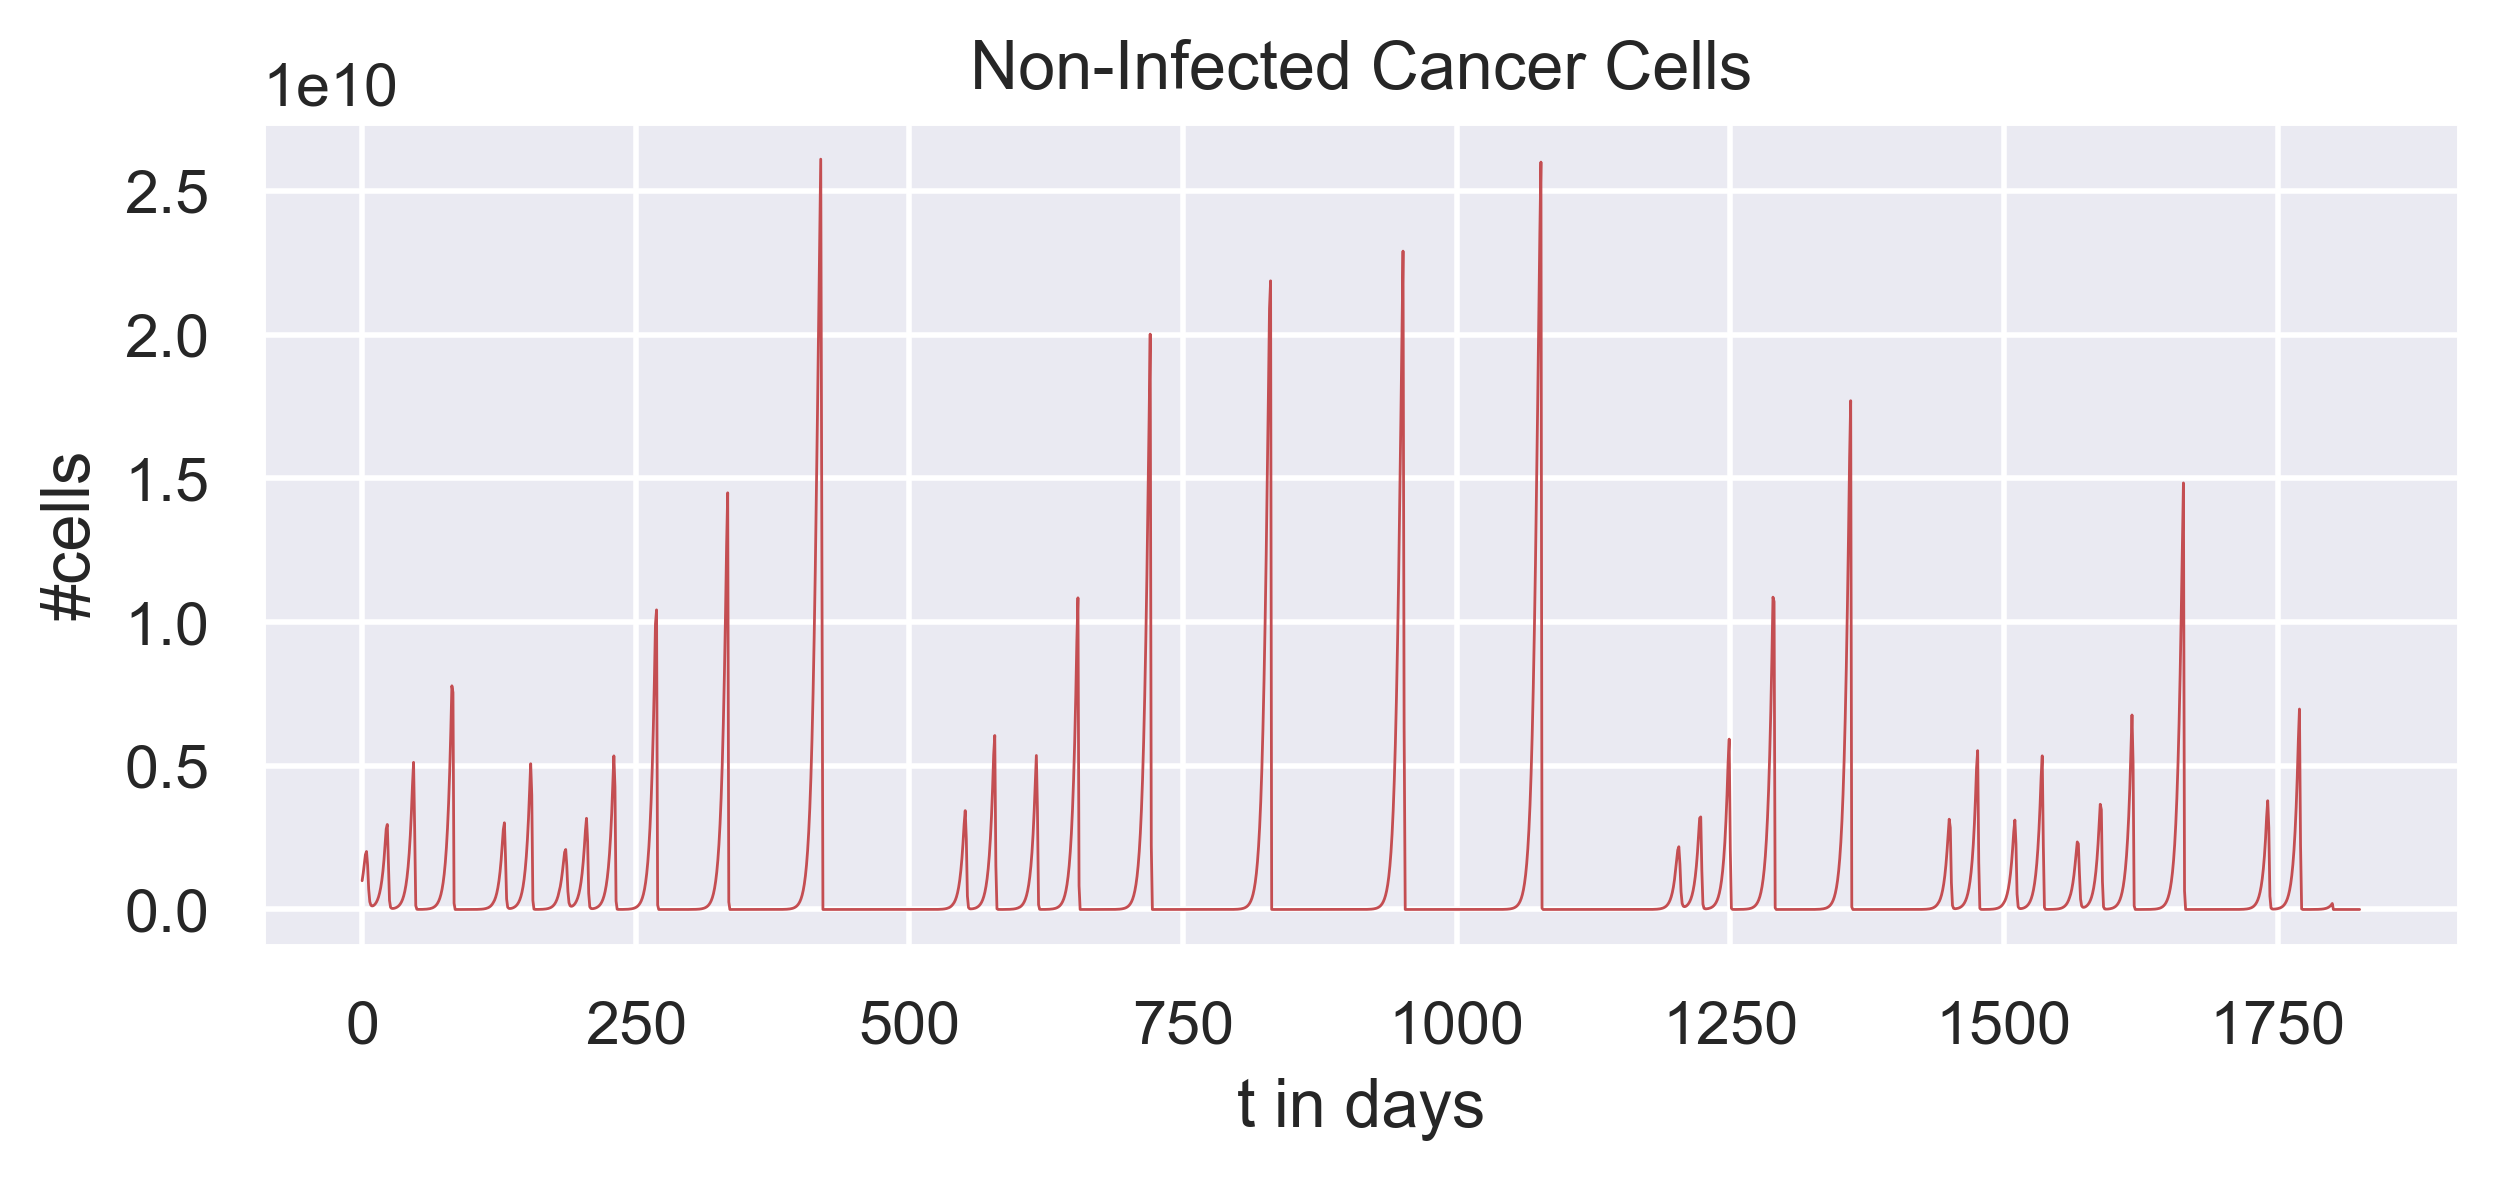

In [54]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), thirty_vaccinations[0], 'r-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Non-Infected Cancer Cells")

plt.show()

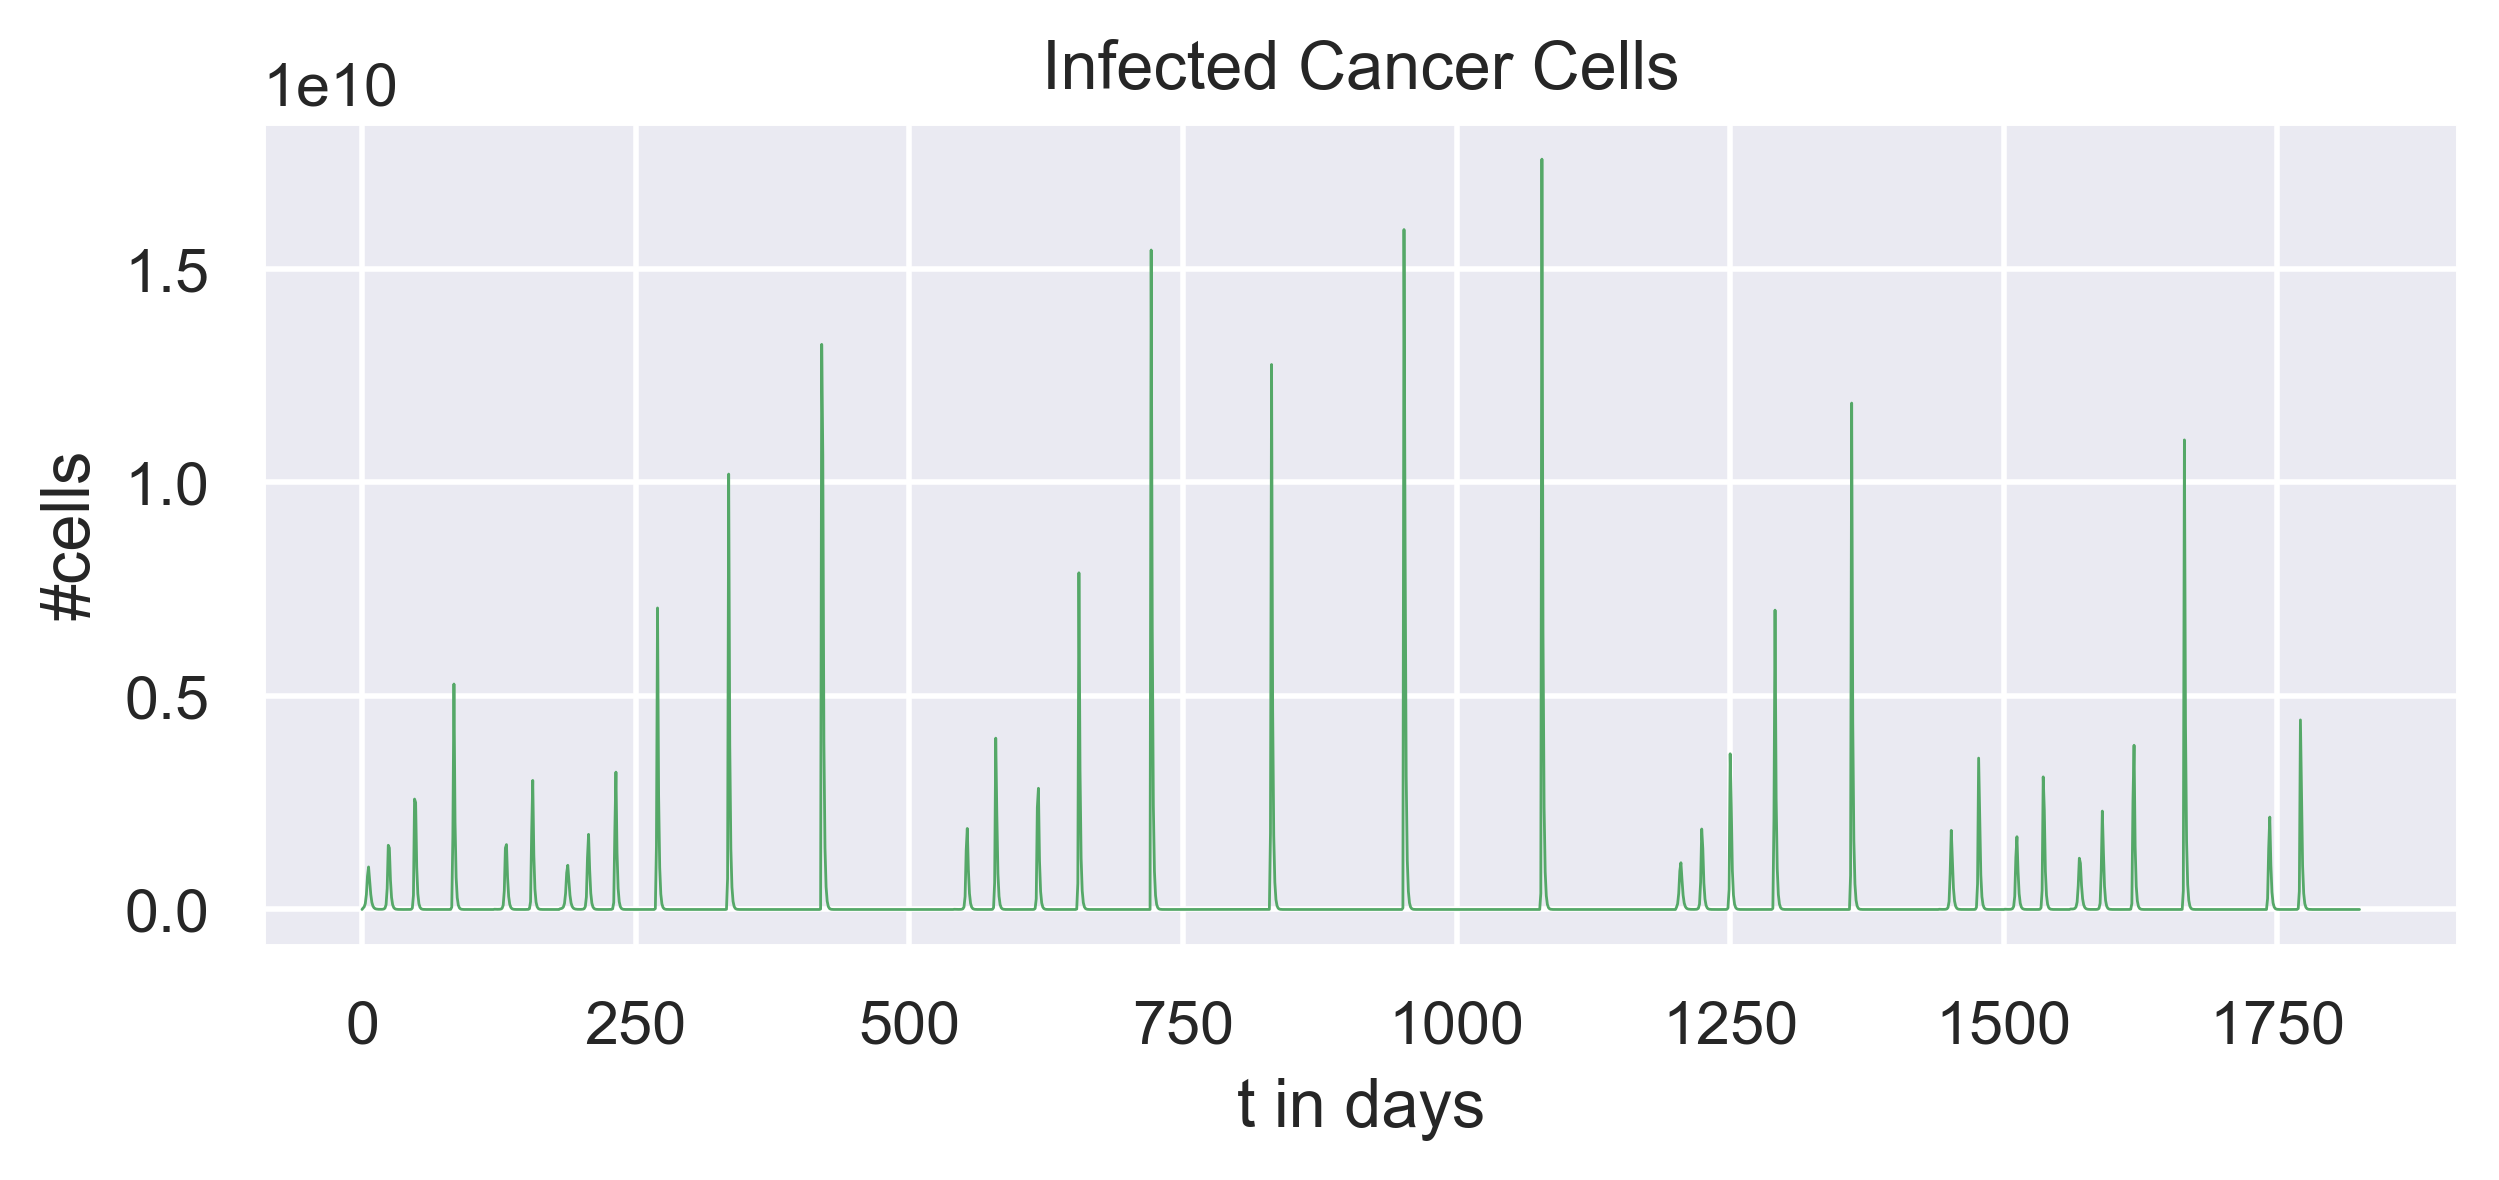

In [55]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), thirty_vaccinations[1], 'g-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Infected Cancer Cells")

plt.show()

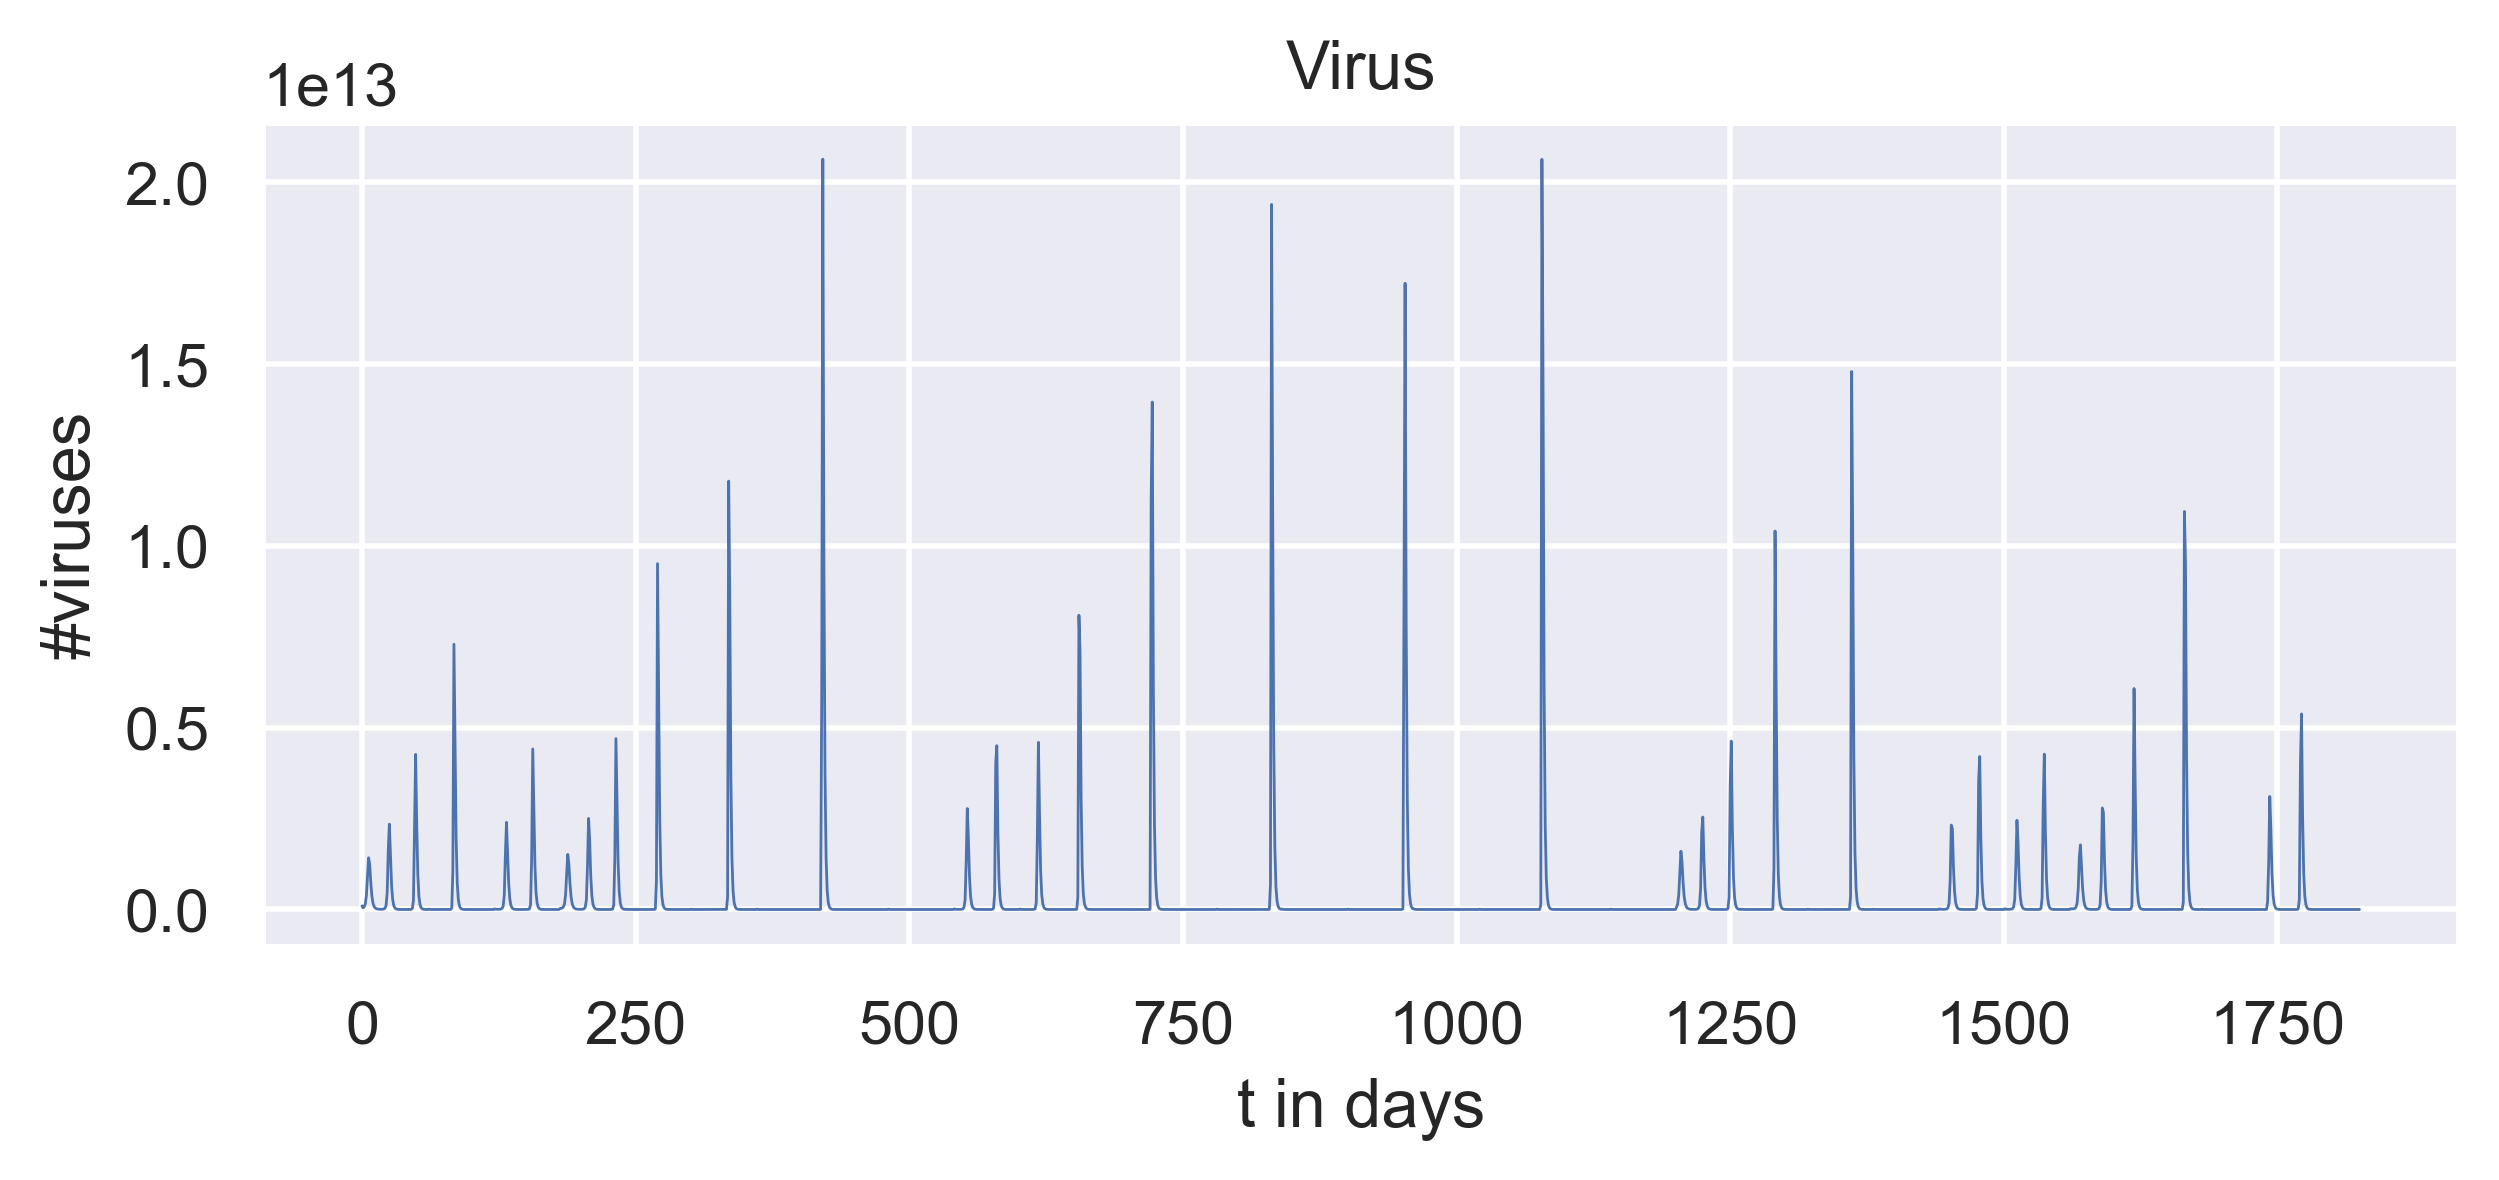

In [56]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,t_end, t_end+1), thirty_vaccinations[2], 'b-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#viruses")
plt.title("Virus")

plt.show()

## 25 Vaccinations with Different Time Lags

In [27]:
twentyfive_vaccinations_treatment = np.array([14, 60, 120])
twentyfive_vaccinations_duration = np.array([4, 12, 9]) * twentyfive_vaccinations_treatment

In [28]:
twentyfive_vaccinations = Non_Constant_Treatment(Clinical_Model, twentyfive_vaccinations_treatment, twentyfive_vaccinations_duration, C0, I0, virus_dose)

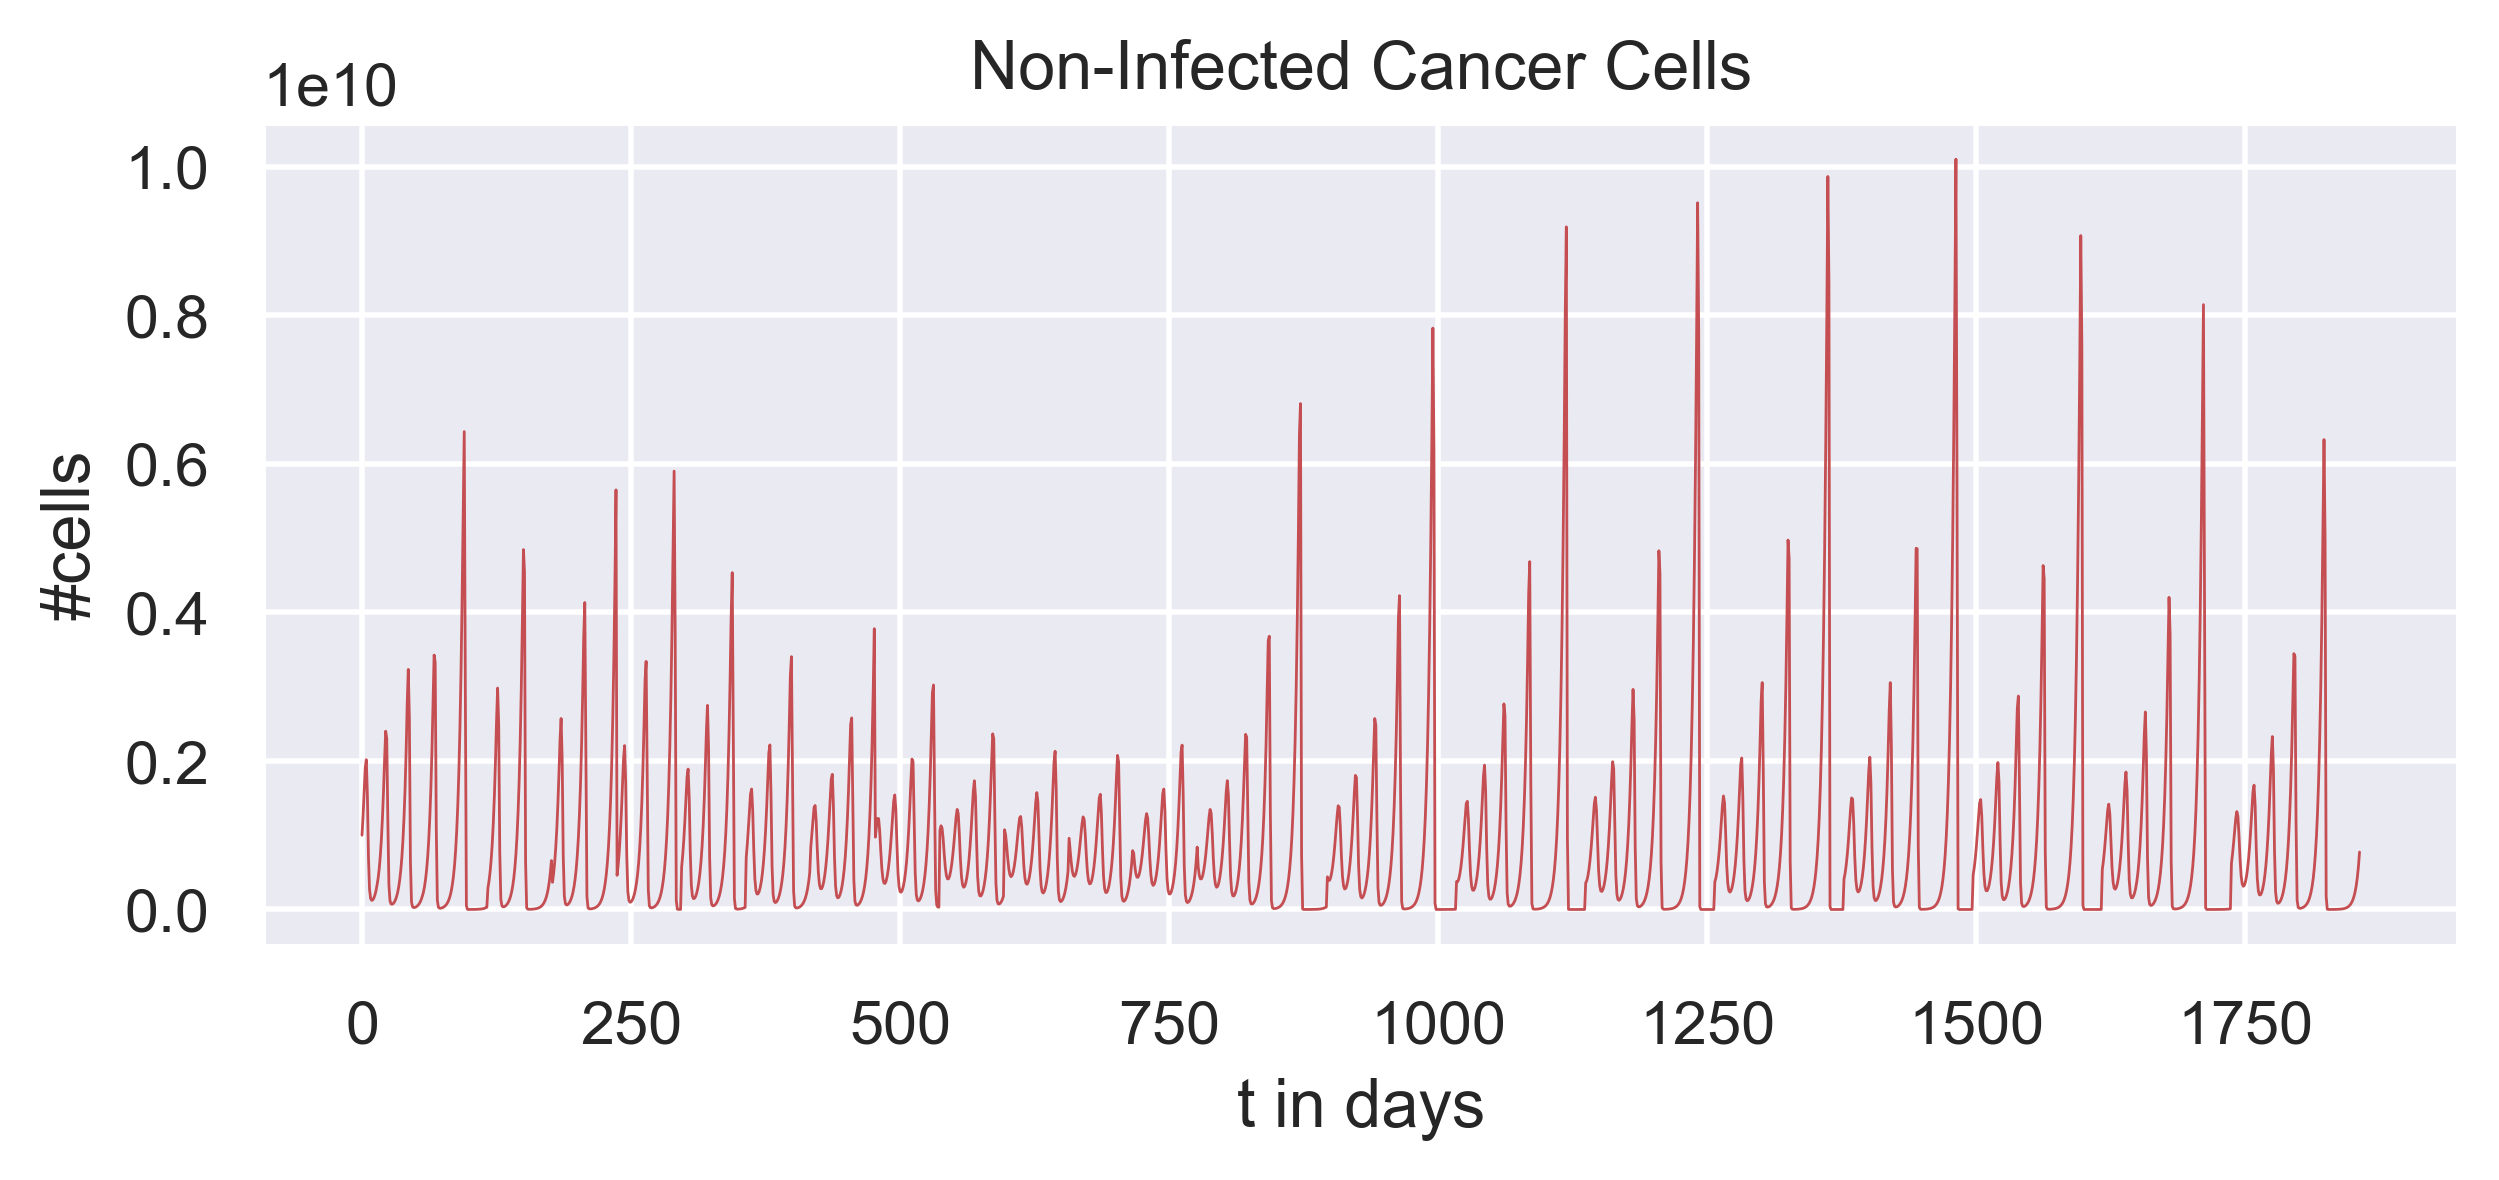

In [57]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,np.sum(twentyfive_vaccinations_duration), np.sum(twentyfive_vaccinations_duration)+1), twentyfive_vaccinations[0], 'r-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Non-Infected Cancer Cells")

plt.show()

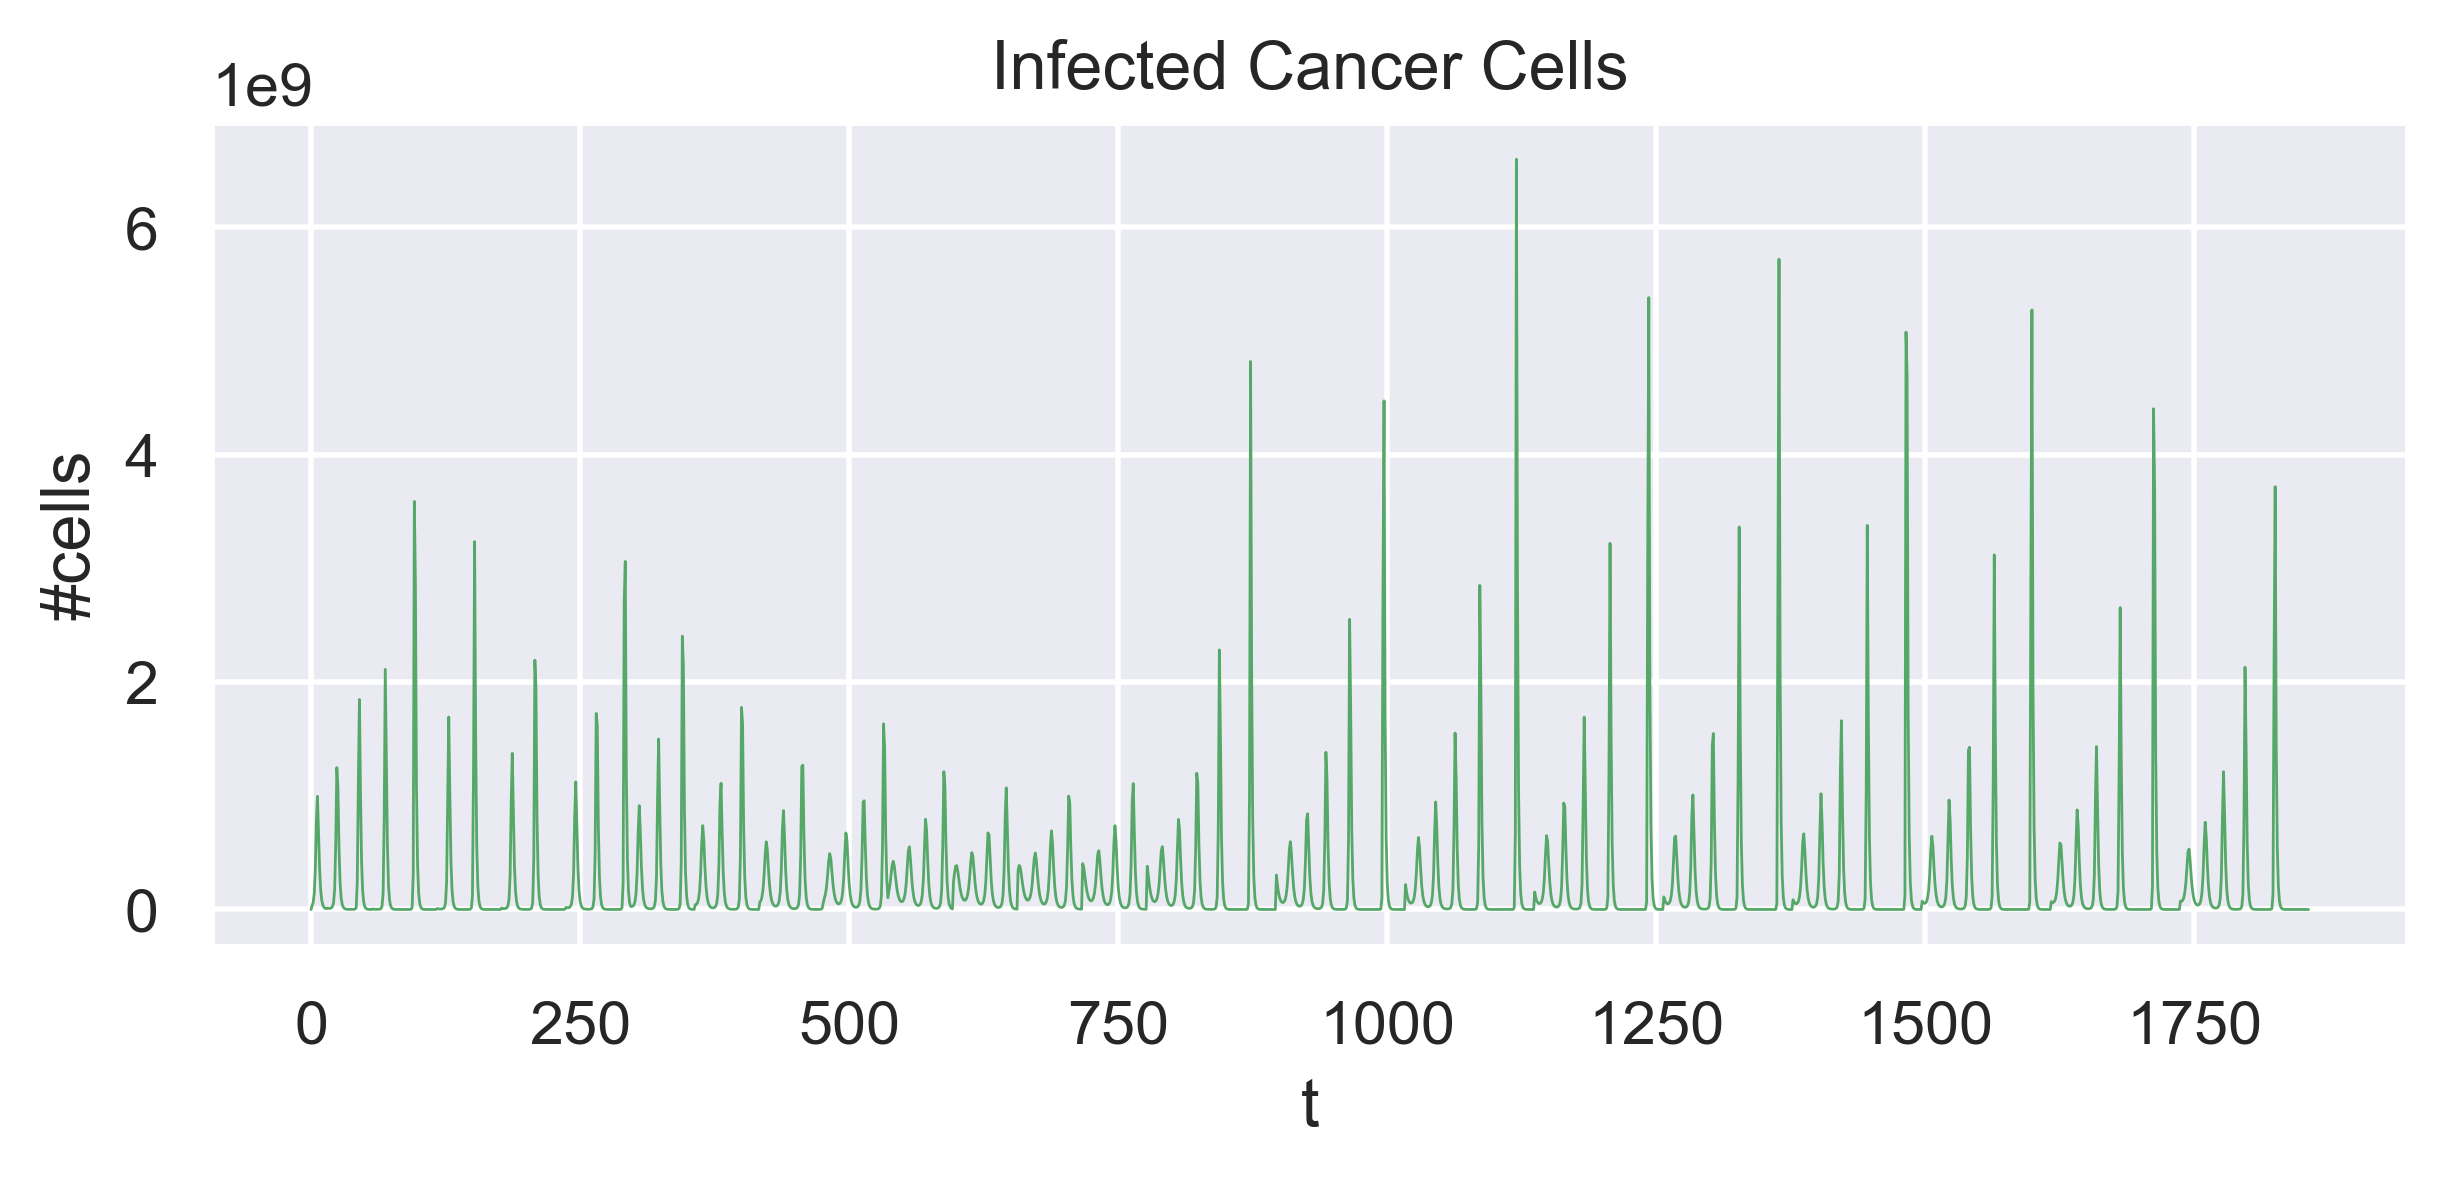

In [58]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,np.sum(twentyfive_vaccinations_duration), np.sum(twentyfive_vaccinations_duration)+1), twentyfive_vaccinations[1], 'g-', linewidth=0.5)
plt.xlabel("t")
plt.ylabel("#cells")
plt.title("Infected Cancer Cells")

plt.show()

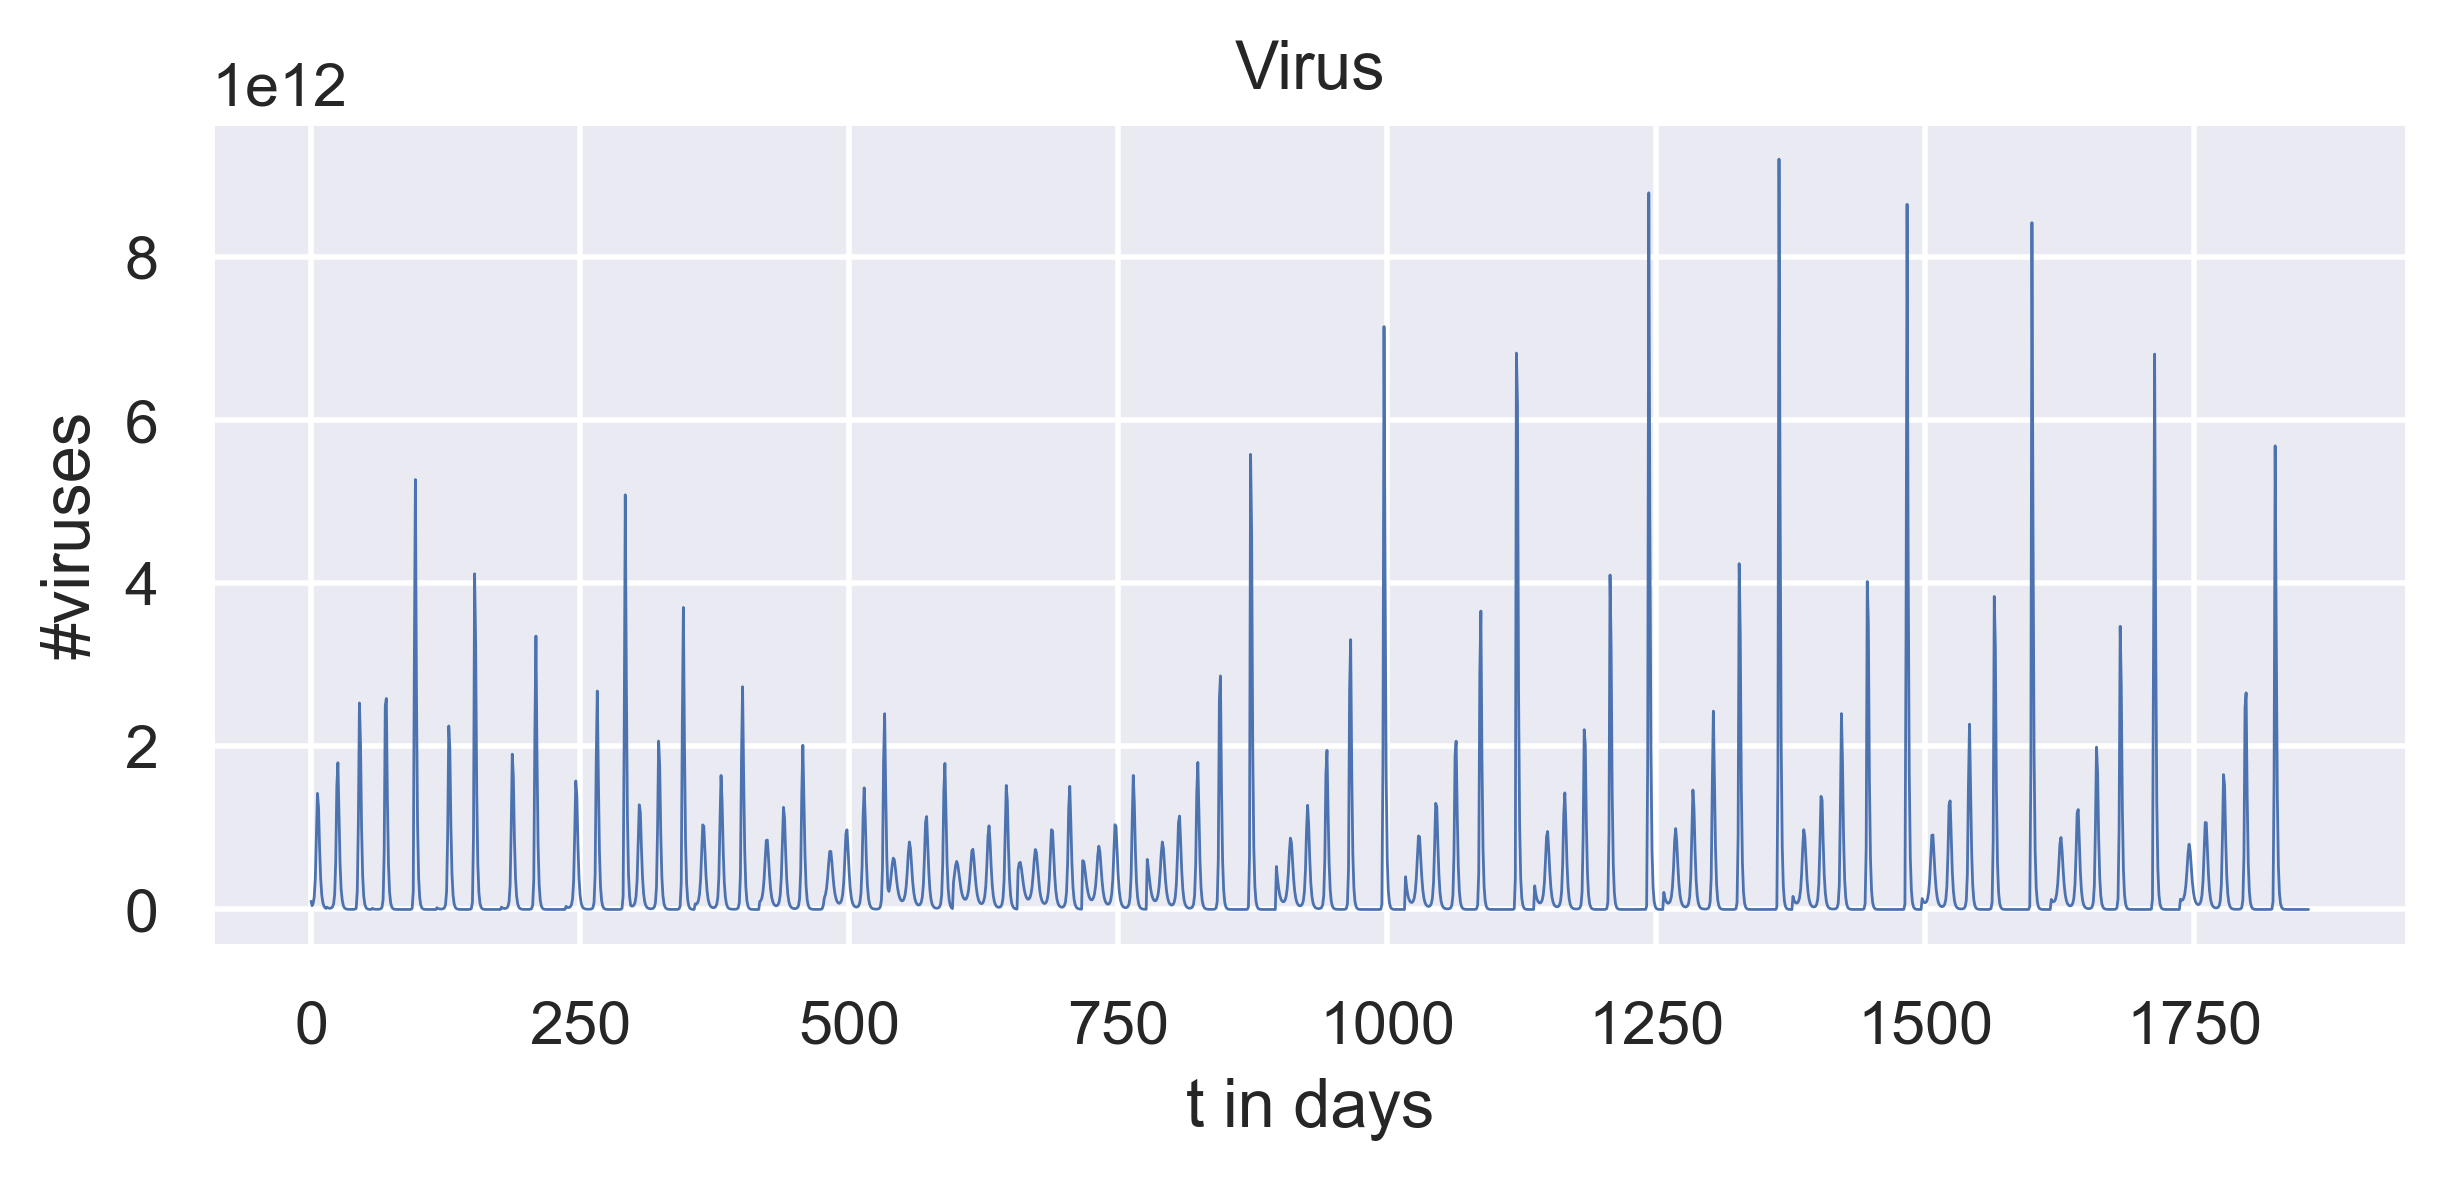

In [59]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,np.sum(twentyfive_vaccinations_duration), np.sum(twentyfive_vaccinations_duration)+1), twentyfive_vaccinations[2], 'b-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#viruses")
plt.title("Virus")

plt.show()

## 34 Vaccinations with Different Time Lags

In [32]:
thirtyfour_vaccinations_treatment = np.array([14, 60])
thirtyfour_vaccinations_duration = np.array([4, 30]) * thirtyfour_vaccinations_treatment

In [33]:
thirtyfour_vaccinations = Non_Constant_Treatment(Clinical_Model, thirtyfour_vaccinations_treatment, thirtyfour_vaccinations_duration, C0, I0, virus_dose)

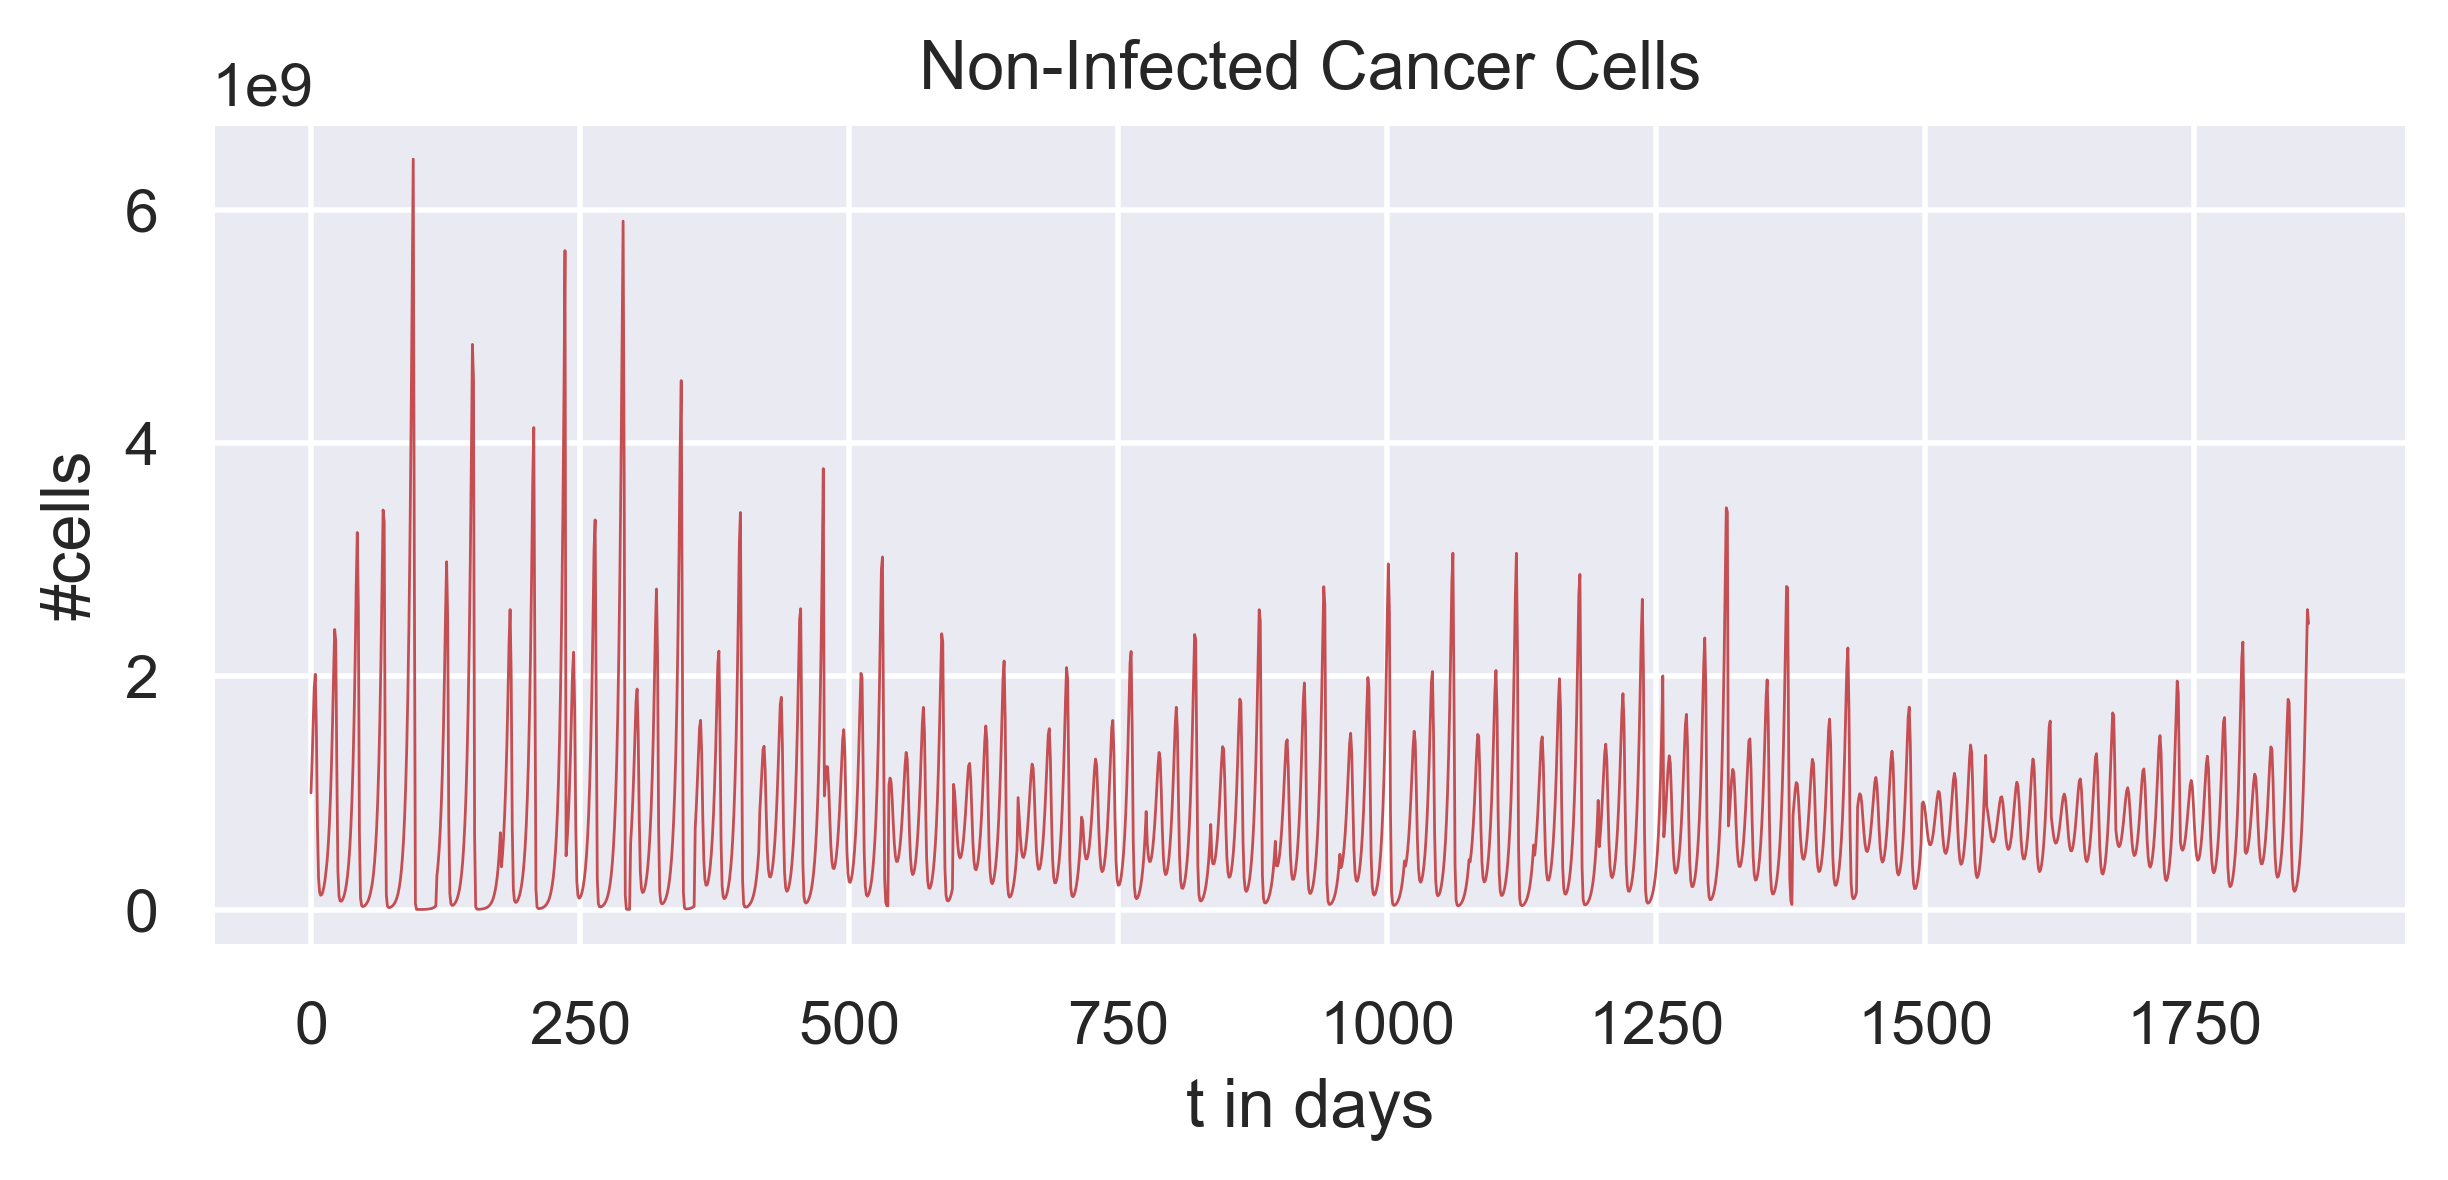

In [60]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,np.sum(thirtyfour_vaccinations_duration), np.sum(thirtyfour_vaccinations_duration)+1), thirtyfour_vaccinations[0], 'r-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#cells")
plt.title("Non-Infected Cancer Cells")

plt.show()

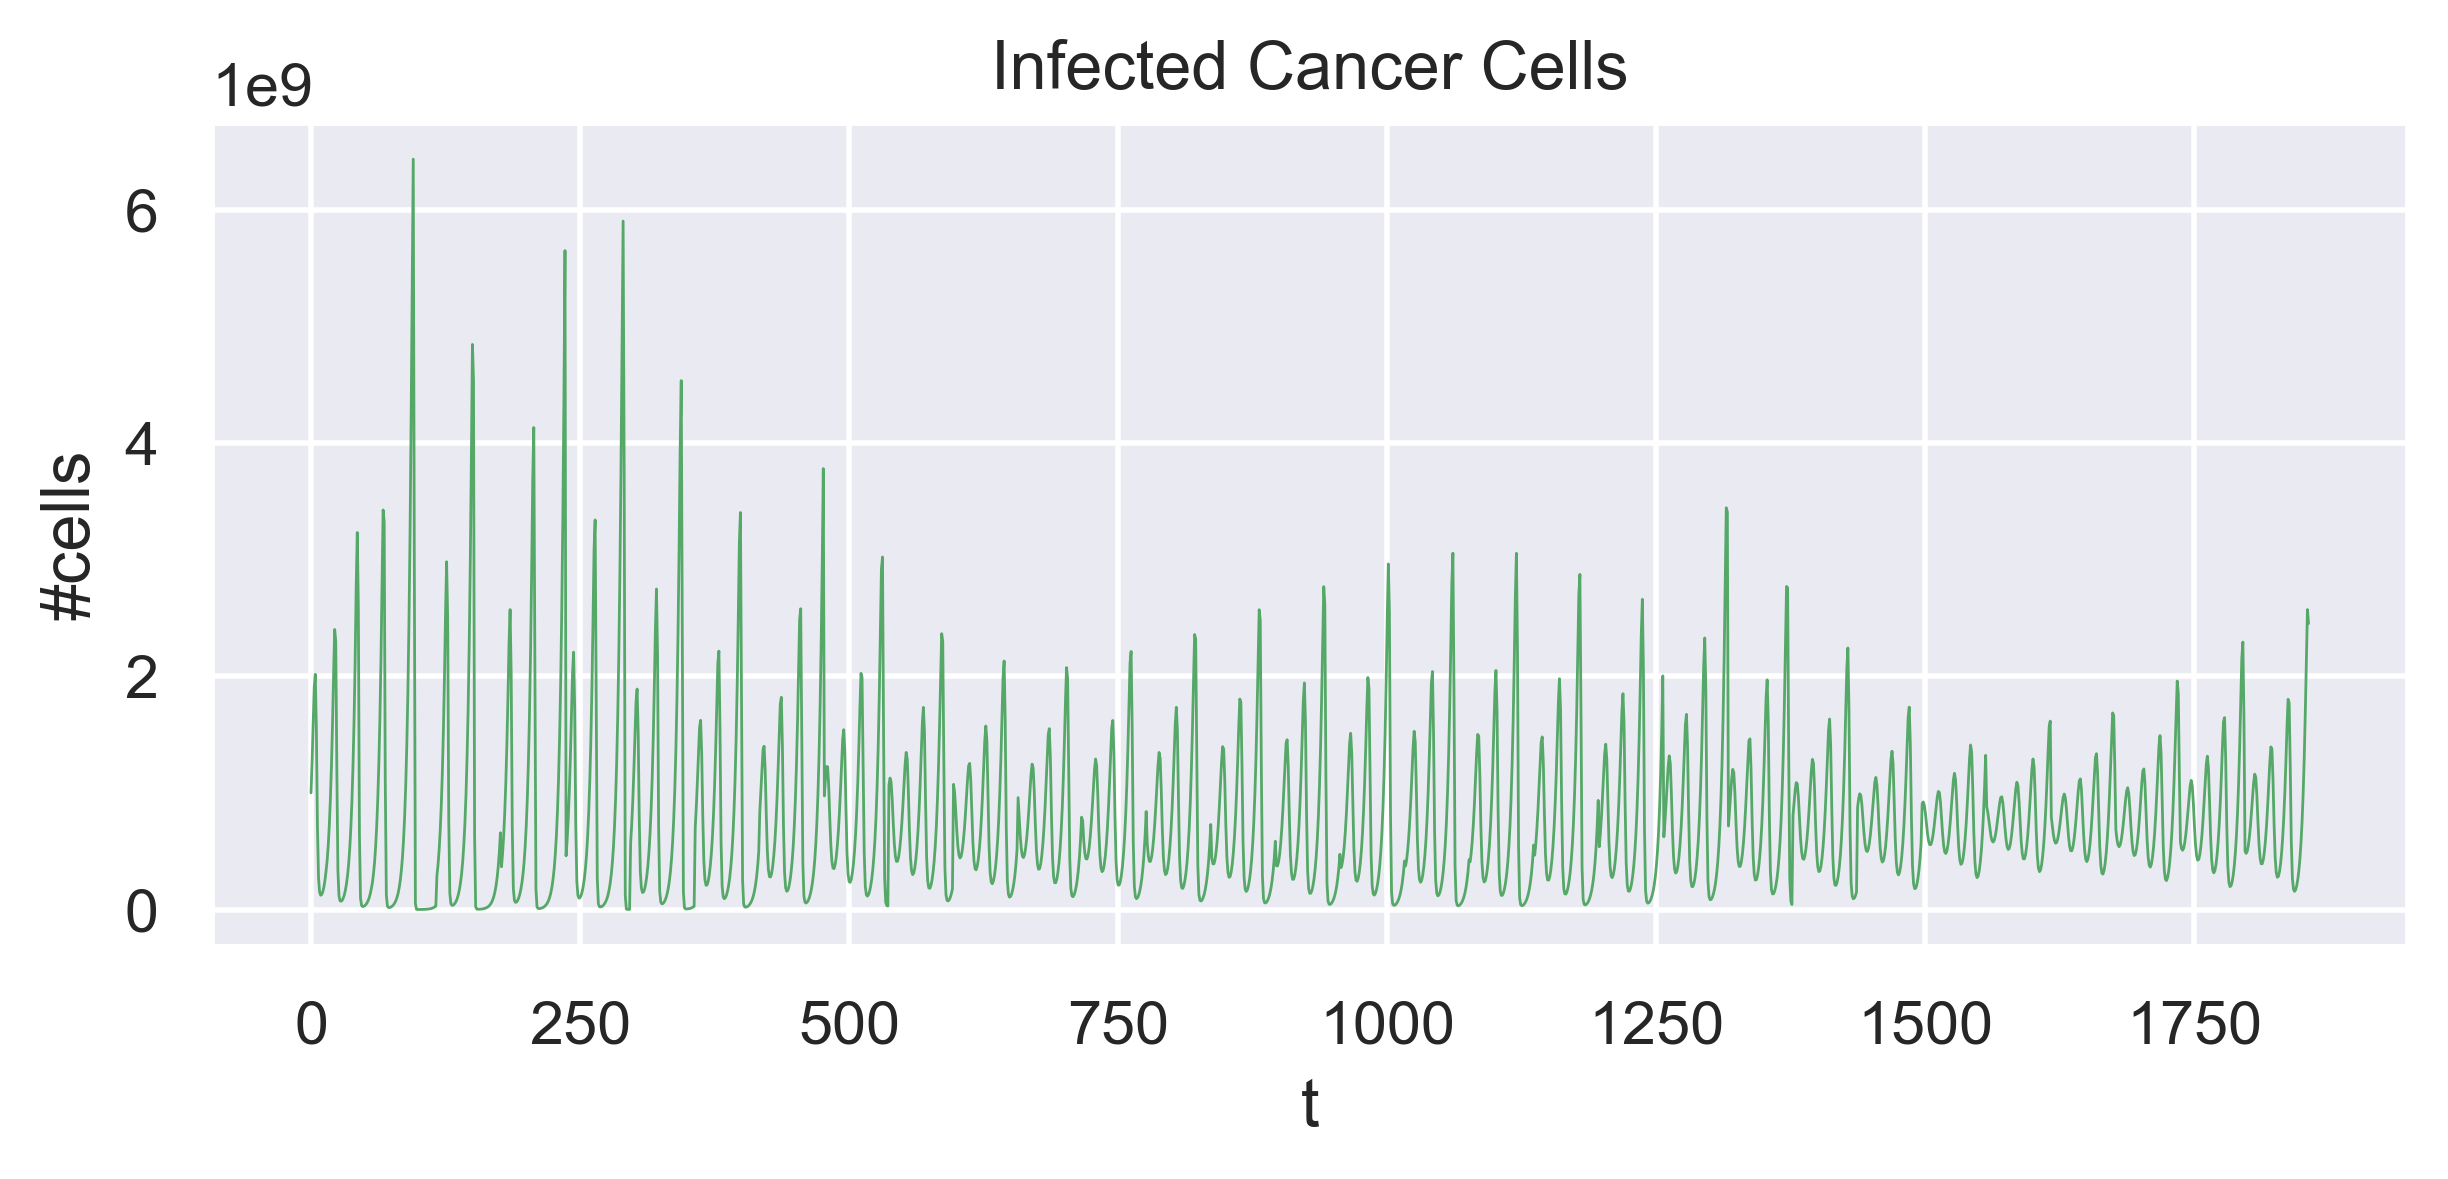

In [61]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,np.sum(thirtyfour_vaccinations_duration), np.sum(thirtyfour_vaccinations_duration)+1), thirtyfour_vaccinations[0], 'g-', linewidth=0.5)
plt.xlabel("t")
plt.ylabel("#cells")
plt.title("Infected Cancer Cells")

plt.show()

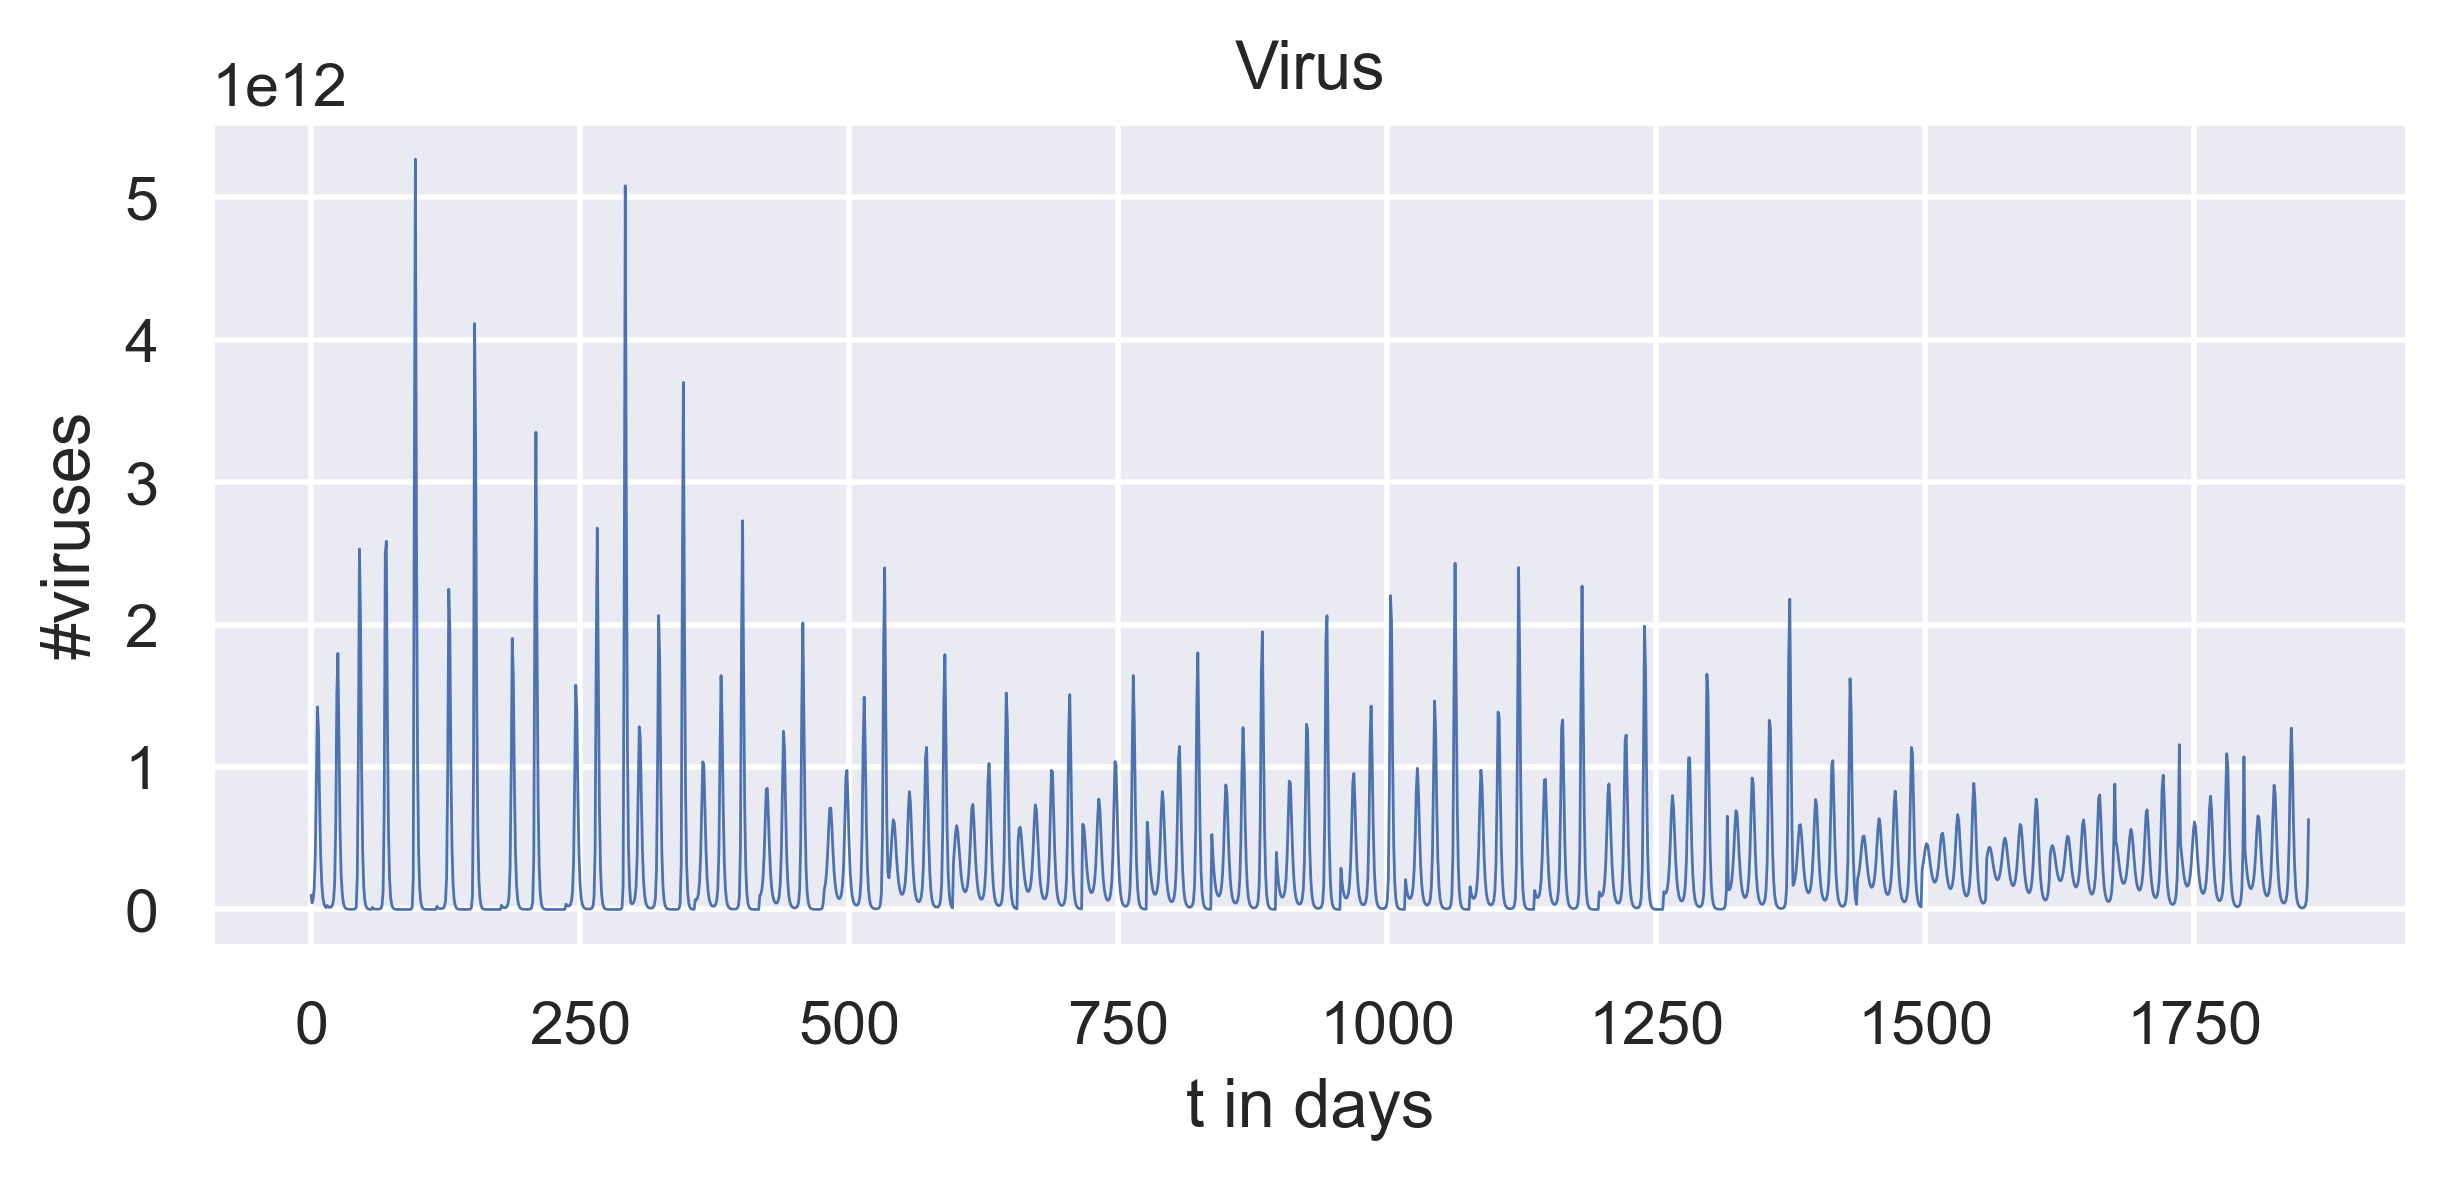

In [62]:
fig = plt.figure(dpi=400, figsize=(7.088, 2.733))

plt.plot(np.linspace(0,np.sum(thirtyfour_vaccinations_duration), np.sum(thirtyfour_vaccinations_duration)+1), thirtyfour_vaccinations[2], 'b-', linewidth=0.5)
plt.xlabel("t in days")
plt.ylabel("#viruses")
plt.title("Virus")

plt.show()

## Maximalwerte

In [37]:
simulationen = ("Simulation 1", "Simulation 2", "Simulation 3", "Simulation 4", "Simulation 5", "Simulation 6")
non_infected_cancer_max = pd.Series([np.max(single_vaccination[0]), np.max(two_vaccinations[0]), np.max(twelve_vaccinations[0]), np.max(thirty_vaccinations[0]), np.max(twentyfive_vaccinations[0]), np.max(thirtyfour_vaccinations[0])], index=simulationen)
infected_cancer_max = pd.Series([np.max(single_vaccination[1]), np.max(two_vaccinations[1]), np.max(twelve_vaccinations[1]), np.max(thirty_vaccinations[1]), np.max(twentyfive_vaccinations[1]), np.max(thirtyfour_vaccinations[1])], index=simulationen)
virus_max = pd.Series([np.max(single_vaccination[2]), np.max(two_vaccinations[2]), np.max(twelve_vaccinations[2]), np.max(thirty_vaccinations[2]), np.max(twentyfive_vaccinations[2]), np.max(thirtyfour_vaccinations[2])], index=simulationen)

In [38]:
maximal_value = pd.DataFrame({"C max": non_infected_cancer_max, "I max": infected_cancer_max, "V max": virus_max})
maximal_value

,C max,I max,V max
Simulation 1,4.119310e+10,3.059643e+10,3.308172e+13
Simulation 2,4.119445e+10,2.765378e+10,3.278567e+13
Simulation 3,4.119693e+10,3.223621e+10,3.195498e+13
Simulation 4,2.609945e+10,1.757063e+10,2.063064e+13
Simulation 5,1.009962e+10,6.600826e+09,9.194867e+12
Simulation 6,6.431922e+09,3.589464e+09,5.268471e+12


## Minimalwerte

In [39]:
simulationen = ("Simulation 1", "Simulation 2", "Simulation 3", "Simulation 4", "Simulation 5", "Simulation 6")
non_infected_cancer_min = pd.Series([np.min(single_vaccination[0]), np.min(two_vaccinations[0]), np.min(twelve_vaccinations[0]), np.min(thirty_vaccinations[0]), np.min(twentyfive_vaccinations[0]), np.min(thirtyfour_vaccinations[0])], index=simulationen)
infected_cancer_min = pd.Series([np.min(single_vaccination[1]), np.min(two_vaccinations[1]), np.min(twelve_vaccinations[1]), np.min(thirty_vaccinations[1]), np.min(twentyfive_vaccinations[1]), np.min(thirtyfour_vaccinations[1])], index=simulationen)
virus_min = pd.Series([np.min(single_vaccination[2]), np.min(two_vaccinations[2]), np.min(twelve_vaccinations[2]), np.min(thirty_vaccinations[2]), np.min(twentyfive_vaccinations[2]), np.min(thirtyfour_vaccinations[2])], index=simulationen)

In [40]:
minimal_value = pd.DataFrame({"C min": non_infected_cancer_min, "I min": infected_cancer_min, "V min": virus_min})
minimal_value

,C min,I min,V min
Simulation 1,4.026464e-14,0.000000e+00,9.709376e-65
Simulation 2,0.000000e+00,-1.344862e-30,-2.194718e-24
Simulation 3,0.000000e+00,0.000000e+00,0.000000e+00
Simulation 4,0.000000e+00,0.000000e+00,0.000000e+00
Simulation 5,1.890437e+03,0.000000e+00,2.186994e+01
Simulation 6,4.150956e+05,0.000000e+00,1.513499e+04
